<a href="https://colab.research.google.com/github/eisbetterthanpi/latent-flow-model/blob/main/latent_flow_matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## setup

In [ ]:
# @title mha me
import torch
import torch.nn as nn

def zero_module(module):
    """Zero out the parameters of a module and return it."""
    for p in module.parameters():
        p.detach().zero_()
    return module

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads=None, d_head=8, cond_dim=None, dropout=0):
        super().__init__()
        self.d_model = d_model
        self.d_head = d_head
        self.n_heads = d_model // d_head
        # self.d_head = d_model // n_heads
        self.cond_dim = cond_dim
        self.q = nn.Linear(d_model, d_model, bias=False)
        self.kv = nn.Linear(cond_dim or d_model, 2*d_model, bias=False)
        # self.k = nn.Sequential(nn.Dropout(dropout), nn.Linear(cond_dim, d_model, bias=False))
        # self.lin = nn.Linear(d_model, d_model)
        self.lin = zero_module(nn.Linear(d_model, d_model))
        self.drop = nn.Dropout(dropout) # indp before q,k,v; after linout
        self.scale = self.d_head ** -.5

    def forward(self, x, cond=None, mask=None): # [batch, T, d_model]=[batch, h*w, c], [batch, num_tok, cond_dim], [batch,T]
        batch = x.shape[0]
        if self.cond_dim==None: cond=x # is self attn
        Q = self.q(x).view(batch, -1, self.n_heads, self.d_head).transpose(1, 2) # [batch, T, d_model] -> [batch, n_heads, T, d_head]
        # K = self.k(x).view(batch, -1, self.n_heads, self.d_head).transpose(1, 2)
        K, V = self.kv(cond).view(batch, -1, self.n_heads, 2*self.d_head).transpose(1, 2).chunk(2, dim=-1) # [batch, n_heads, T/num_tok, d_head]

        # linear attention # Softmax(Q) @ (Softmax(K).T @ V)
        if mask != None:
            mask = mask[:, None, :, None] # [batch,T] -> [batch,1,T,1]
            K, V = K.masked_fill(mask, -torch.finfo(x.dtype).max), V.masked_fill(mask, -torch.finfo(x.dtype).max)
        Q, K = Q.softmax(dim=-1)*self.scale, K.softmax(dim=-2)
        context = K.transpose(-2,-1) @ V # [batch, n_heads, d_head, d_head]
        out = Q @ context # [batch, n_heads, T/num_tok, d_head]

        # # (quadratic) attention # Softmax(Q @ K.T) @ V
        # attn = Q @ K.transpose(-2,-1) * self.scale # [batch, n_heads, T] # [batch, n_heads, T, T/num_tok]
        # if mask != None: attn = attn.masked_fill(mask[:, None, :, None], -torch.finfo(attn.dtype).max) # [batch,T]->[batch,1,T,1]
        # attention = torch.softmax(attn, dim=-1)
        # out = self.drop(attention) @ V # [batch, n_heads, T, d_head]

        out = out.transpose(1, 2).flatten(2)
        return self.lin(out) # [batch, T, d_model]

# if self, dont pass cond_dim in init, dont pass cond in fwd
# Softmax(Q @ K.T) @ V ~ Softmax(Q) @ Softmax(K).T @ V


class AttentionBlock(nn.Module):
    def __init__(self, d_model, d_head, cond_dim=None, ff_dim=None, dropout=0.):
        super().__init__()
        self.d_model = d_model
        self.norm1 = nn.RMSNorm(d_model) # LayerNorm RMSNorm
        self.norm2 = nn.RMSNorm(d_model)
        self.drop = nn.Dropout(dropout)
        self.cond_dim = cond_dim
        self.self = MultiHeadAttention(d_model, d_head=d_head, dropout=0)
        self.cross = MultiHeadAttention(d_model, d_head=d_head, cond_dim=cond_dim, dropout=0)
        act = nn.ReLU()
        if ff_dim==None: ff_dim=d_model*4
        self.ff = nn.Sequential(
            # nn.RMSNorm(d_model), nn.Linear(d_model, ff_dim), nn.ReLU(), # ReLU GELU
            # nn.RMSNorm(d_model), nn.Dropout(dropout), nn.Linear(ff_dim, d_model)
            nn.RMSNorm(d_model), act, nn.Linear(d_model, ff_dim),
            nn.RMSNorm(ff_dim), act, nn.Linear(ff_dim, d_model)
        )

    def forward(self, x, cond=None, mask=None): # [b,c,h,w], [batch, num_tok, cond_dim], [batch,T]
        bchw = x.shape
        x = x.flatten(2).transpose(1,2) # [b,h*w,c]
        if self.cond_dim==None: cond=None # is self attn
        # x = self.norm1(x + self.drop(self.cross_attn(x, cond)))
        # x = self.norm2(x + self.drop(self.ff(x)))
        x = x + self.self(self.norm1(x))
        x = x + self.cross(self.norm2(x), cond, mask)
        x = x + self.ff(x)
        return x.transpose(1,2).reshape(*bchw)


d_model=8
d_head=4
batch=4
h,w=5,6
x=torch.rand(batch,d_model,h,w)
cond_dim=10
model = AttentionBlock(d_model=d_model, d_head=d_head,cond_dim=cond_dim)
num_tok=1
cond=torch.rand(batch,num_tok,cond_dim)
mask=torch.rand(batch,h*w)>0.5
out = model(x, cond, mask)
print(out.shape)
# print(out)


torch.Size([4, 8, 5, 6])


In [ ]:
# @title RotEmb
import torch
import torch.nn as nn
device = "cuda" if torch.cuda.is_available() else "cpu"

class RotEmb(nn.Module): # Rotary Positional Embeddings
    def __init__(self, dim, top=torch.pi, base=10000):
        super().__init__()
        self.theta = top / (base ** (torch.arange(0, dim, step=2, device=device) / dim))

    def forward(self, pos): # [batch] in [0,1]
        angles = (pos.unsqueeze(-1) * self.theta).unsqueeze(-1) # [seq_len, 1] * [dim // 2] -> [seq_len, dim // 2, 1]
        rot_emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1) # [seq_len, dim // 2, 2]
        return rot_emb.flatten(-2) # [seq_len, dim]

# class LearnedSinusoidalPosEmb(nn.Module):
#     """ https://github.com/crowsonkb/v-diffusion-jax/blob/master/diffusion/models/danbooru_128.py#L8 """
#     def __init__(self, dim):
#         super().__init__()
#         half_dim = dim // 2
#         self.weights = nn.Parameter(torch.randn(1, half_dim))

#     def forward(self, x): # [b]
#         x = x.unsqueeze(-1)
#         freqs = x * self.weights * 2 * math.pi # [b, 1] * [1, half_dim] = [b, half_dim]
#         fouriered = torch.cat((freqs.sin(), freqs.cos()), dim = -1) # [b, dim]
#         fouriered = torch.cat((x, fouriered), dim = -1) # [b, 1+dim]
#         return fouriered

# rotemb = RotEmb(10)
# seq_len=10
# pos = torch.linspace(0,1,seq_len).to(device)#.unsqueeze(-1)
# rot_emb = rotemb(pos)
# print(rot_emb)

In [ ]:
# @title CrossEmbedLayer PixelShuffleConv
import torch
from torch import nn
from torch.nn import functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class CrossEmbedLayer(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_sizes, stride=1):
        super().__init__()
        kernel_sizes = sorted(kernel_sizes)

        r=2
        balls = out_ch//r**2
        mult = [1/(1.6**i) for i in range(len(kernel_sizes))]
        mul = balls/sum(mult)
        mult = [m*mul for m in mult]
        dim_scales = [0]*len(kernel_sizes)
        for i in range(balls):
            ind = mult.index(max(mult))
            dim_scales[ind] += 1
            mult[ind] -= 1
        dim_scales = [d*r**2 for d in dim_scales]
        if 0 in dim_scales: print('dim_scales',dim_scales)
        # 1/2 + 1/4 + 1/8 + ... + 1/2^num_kernels + 1/2^num_kernels of out_ch; smaller kernel allocated more channels
        self.convs = nn.ModuleList([nn.Conv2d(in_ch, dim_scale, kernel, stride=stride, padding=(kernel-stride)//2) for kernel, dim_scale in zip(kernel_sizes, dim_scales)])

    def forward(self, x):
        # return torch.cat([conv(x) for conv in self.convs], dim = 1)
        out = torch.cat([conv(x) for conv in self.convs], dim = 1)
        b,c,h,w = out.shape
        out = out.reshape(b, -1, 4, h, w).transpose(1,2).reshape(b, c, h, w)
        return out


class PixelShuffleConv(nn.Module):
    def __init__(self, in_ch, out_ch = None, kernel_size=3, r=2):
        super().__init__()
        if out_ch==None: out_ch = in_ch
        self.in_ch, self.out_ch, self.r = in_ch, out_ch, r
        r = max(r, int(1/r))
        if self.r>1: self.net = nn.Sequential(nn.Conv2d(in_ch, out_ch * r**2, kernel_size, 1, padding=kernel_size//2), nn.PixelShuffle(r)) # PixelShuffle: [b,c*r^2,h,w] -> [b,c,h*r,w*r] # upscale by upscale factor r # https://arxiv.org/pdf/1609.05158v2
        elif self.r<1: self.net = nn.Sequential(nn.PixelUnshuffle(r), nn.Conv2d(in_ch * r**2, out_ch, kernel_size, 1, padding=kernel_size//2)) # PixelUnshuffle: [b,c,h*r,w*r] -> [b,c*r^2,h,w]
        self.net.apply(self.init_conv_)

    def init_conv_(self, conv): # weight initialisation very important for the performance of pixelshuffle!
        if isinstance(conv, nn.Conv2d):
            o, i, h, w = conv.weight.shape
            conv_weight = torch.empty(self.out_ch, self.in_ch, h, w)
            nn.init.kaiming_uniform_(conv_weight)
            # print(conv.weight.shape, conv_weight.shape,max(self.r, int(1/self.r)), (0 if self.r>1 else 1))
            conv.weight.data.copy_(conv_weight.repeat_interleave(max(self.r, int(1/self.r))**2, dim=(0 if self.r>1 else 1)))
            nn.init.zeros_(conv.bias.data)

    def forward(self, x):
        return self.net(x)


# d=PixelShuffleConv(3, 16, 7, r=1/2)

# device = "cuda" if torch.cuda.is_available() else "cpu"
# model = PixelShuffleConv(in_ch=3, r=2).to(device)
# print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 16x16 conv 17651 ; pixel(3)(3)  ; (1)(1)  ; (3,7,15)(3,7)  ; (3,5,7)(3,5) 42706 ; 7,5 70226
# input = torch.rand((4,3,64,64), device=device)
# out = model(input)
# print(out.shape)

# model = PixelShuffleConv(in_ch=3, r=1/2).to(device)
# out = model(input)
# print(out.shape)




In [ ]:
# @title unet me
import torch
import torch.nn as nn
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"
# torch.set_default_dtype(torch.float16)

import inspect
class Seq(nn.Sequential):
    def __init__(self, *args):
        super().__init__(*args)
        for layer in self:
            params = inspect.signature(layer.forward).parameters.keys()
            layer._fwdparams = ','.join(params)

    def forward(self, x, emb=None, cond=None):
        for layer in self:
            args = [x]
            if 'emb' in layer._fwdparams: args.append(emb)
            if 'cond' in layer._fwdparams: args.append(cond)
            x = layer(*args)
        return x

class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch=None, emb_dim=None, drop=0.):
        super().__init__()
        if out_ch==None: out_ch=in_ch
        act = nn.SiLU() #
        self.block1 = nn.Sequential(nn.BatchNorm2d(in_ch), act, nn.Conv2d(in_ch, out_ch, 3, padding=1))
        self.block2 = Seq(nn.BatchNorm2d(out_ch), scale_shift(out_ch, emb_dim) if emb_dim != None else nn.Identity(), act, nn.Conv2d(out_ch, out_ch, 3, padding=1))
        # self.res_conv = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()
        self.res_conv = zero_module(nn.Conv2d(in_ch, out_ch, 1)) if in_ch != out_ch else nn.Identity()

    def forward(self, x, emb=None): # [b,c,h,w], [batch, emb_dim]
        h = self.block1(x)
        h = self.block2(h, emb)
        return h + self.res_conv(x)

class scale_shift(nn.Module): # FiLM
    def __init__(self, x_dim, t_dim):
        super().__init__()
        self.time_mlp = nn.Sequential(nn.SiLU(), nn.Linear(t_dim, x_dim*2),)

    def forward(self, x, emb): # [b,c,h,w], [b,emb_dim]
        scale, shift = self.time_mlp(emb)[..., None, None].chunk(2, dim=1) # [b,t_dim]->[b,2*x_dim,1,1]->[b,x_dim,1,1]
        return x * (scale + 1) + shift

class levelBlock(nn.Module):
    def __init__(self, in_ch, out_ch, emb_dim, cond_dim, n_head=None, d_head=8, updown=False, r=2):
        super().__init__()
        if updown=='down': in_ch = in_ch*r**2
        elif updown=='up': out_ch = out_ch*r**2
        if n_head==None: n_head = out_ch // d_head
        layers = [
            nn.PixelUnshuffle(r) if updown=='down' else nn.Identity(),
            ResBlock(in_ch, out_ch, emb_dim=emb_dim),
            AttentionBlock(out_ch, d_head, cond_dim),
            nn.PixelShuffle(r) if updown=='up' else nn.Identity(),
            ]
        self.seq = Seq(*layers)

    def forward(self, x, emb=None, cond=None):
        return self.seq(x, emb, cond)


class UNet(nn.Module):
    def __init__(self, in_ch=3, d_model=16, out_ch=None, cond_dim=16, depth=4, num_res_blocks=1, n_head=-1, d_head=4):
        super().__init__()
        self.in_ch = in_ch
        self.d_model = d_model # base channel count for the model
        out_ch = out_ch or in_ch
        n_head = d_model // d_head

        self.rotemb = RotEmb(d_model)
        emb_dim = d_model# * 4
        self.time_emb = nn.Sequential(nn.Linear(d_model, emb_dim), nn.SiLU(), nn.Linear(emb_dim, emb_dim))

        self.in_block = nn.Sequential(nn.Conv2d(in_ch, d_model, 3, padding=1))
        # self.init_conv = CrossEmbedLayer(in_ch, dim_out=d_model, kernel_sizes=(3, 7, 15), stride=1) #if init_cross_embed else nn.Conv2d(in_ch, d_model, 7, padding = 7//2)

        mult = [1,2,3,4] # [1,2,3,4] [1,2,2,2]
        ch_list = [d_model * m for m in mult[:depth+1]] # [128, 256, 384, 512]

        self.down_list = nn.ModuleList([levelBlock(ch_list[i], ch_list[i+1], emb_dim, cond_dim, updown=None if i==0 else 'down') for i in range(depth)])
        # self.down_list = nn.ModuleList([levelBlock(ch_list[i], ch_list[i+1], emb_dim, cond_dim, updown='down') for i in range(depth)])

        ch = ch_list[-1]*2**2 # 512
        self.middle_block = Seq(
            nn.PixelUnshuffle(2), ResBlock(ch, ch, emb_dim),
            AttentionBlock(ch, d_head, cond_dim),
            ResBlock(ch, ch, emb_dim), nn.PixelShuffle(2),
        )
        self.up_list = nn.ModuleList([levelBlock(2*ch_list[i+1], ch_list[i], emb_dim, cond_dim, updown=None if i==0 else 'up') for i in reversed(range(depth))])
        # self.up_list = nn.ModuleList([levelBlock(2*ch_list[i+1], ch_list[i], emb_dim, cond_dim, updown='up') for i in reversed(range(depth))])

        # self.out_block = nn.Sequential(nn.BatchNorm2d(d_model), nn.SiLU(), nn.Conv2d(d_model, out_ch, 3, padding=1)) # zero
        self.out_block = nn.Sequential(nn.BatchNorm2d(d_model), nn.SiLU(), zero_module(nn.Conv2d(d_model, out_ch, 3, padding=1))) # zero
        # self.final_conv = nn.Conv2d(d_model, self.out_ch, 3, padding = 3//2) # lucid; or prepend final res block

    def forward(self, x, t=None, cond=None): # [N, c,h,w], [N], [N, cond_dim]
        t_emb = self.rotemb(t)
        emb = self.time_emb(t_emb) #+ self.label_emb(y) # class conditioning nn.Embedding(num_classes, emb_dim)

        blocks = []
        x = self.in_block(x)
        for i, down in enumerate(self.down_list):
            x = down(x, emb, cond)
            blocks.append(x)
        x = self.middle_block(x, emb, cond)
        for i, up in enumerate(self.up_list):
            # print("unet fwd", x.shape,blocks[-i-1].shape)
            x = torch.cat([x, blocks[-i-1]*2**.5], dim=1) # scale residuals by 1/sqrt2
            x = up(x, emb, cond) # x = up(x, blocks[-i - 1])
        return self.out_block(x)



# # 64,64 -vae-> 16,16 -unet->
# batch = 4
# cond_dim=10
# in_ch = 3
# model = UNet(in_ch=in_ch, d_model=16, cond_dim=cond_dim, depth=3).to(device)
# print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 19683
# # print(model)

# x=torch.rand((batch,in_ch,16,16),device=device)
# t = torch.rand((batch,), device=device) # in [0,1] [N]
# cond=torch.rand((batch,cond_dim),device=device)
# out = model(x, t, cond)
# print(out.shape)

# optim = torch.optim.AdamW(model.parameters(), lr=1e-3) # 1e-3 3e-3
# # cond_emb = nn.Embedding(10, cond_dim).to(device)


5313395
torch.Size([4, 3, 16, 16])


In [ ]:
# @title data
import torchvision
import torchvision.transforms as transforms

train_data = torchvision.datasets.MNIST(root="data", train=True, download=True,transform=transforms.ToTensor(),) # do not normalise! want img in [0,1)
batch_size = 512 # 64 512
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data = torchvision.datasets.MNIST(root="data", train=False, download=True, transform=transforms.ToTensor(),) #opt no download
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

# dataiter = iter(train_data)
# x,y = next(dataiter)
# print(x)

In [ ]:
# @title LogitNormal
import torch
import torch.distributions as dist
import torch.nn.functional as F

class LogitNormal(dist.Distribution):
    def __init__(self, mu=0, std=.5):
        super().__init__()
        self.mu, self.std = mu, std
        self._normal = dist.Normal(mu, std) # https://pytorch.org/docs/stable/distributions.html#normal

    def rsample(self, sample_shape=torch.Size()):
        eps = self._normal.rsample(sample_shape)
        return torch.sigmoid(eps) # https://en.wikipedia.org/wiki/Logit-normal_distribution

logit_normal = LogitNormal()
# samples = logit_normal.rsample((10,))
# print(samples)


/usr/local/lib/python3.11/dist-packages/torch/distributions/distribution.py:56: UserWarning: <class '__main__.LogitNormal'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


In [ ]:
# @title sampling timestep
# def InverseSigmoid(x): return torch.log(x/(1-x))
# def Normal(x, mu=0, std=.5): return torch.exp(-.5*((x-mu)/std)**2)/(std*(2*torch.pi)**2)
# def LogitNormalPDF(x, mu=0, std=.5): return torch.nan_to_num(Normal(logit(x), mu, std) * 1/(x*(1-x)))

# def invlogit(x): return torch.exp(x)/(1+torch.exp(x))
# def InvLogitNormalCDF(x, mu=0, std=.5):
#     cdf = invlogit(torch.erfinv(2*x-1)*(2**.5*std)+mu)
#     cdf[x==1.] = 1 # lol, replace nan with 1 when x=1
#     return cdf

def logit(x): return torch.log(x/(1-x)) # x in (0,1)
def LogitNormalCDF(x, mu=0, std=.5): # _/- for std<1.8; /-/ for std>1.8
    cdf = 1/2 * (1 + torch.erf((logit(x)-mu)/(2**.5*std)))
    return cdf

def Cosine(x): return .5*(-torch.cos(torch.pi*x)+1) # _/-
def Polynomial(x): return -2*x**3 + 3*x**2 # -2x^3 + 3x^2 # _/-
def ACosine(x): return torch.acos(1-2*x)/torch.pi # /-/ # x = acos(1-2y)/pi
def InvertCubic(x): return (x-1)**3+1 # /-
def InvertExp(x, a=4): return (1-torch.exp(-a*x)) / (1-torch.exp(torch.tensor(-a))) # /-


a, b = .0, 0
def bezier(t, x0=0,y0=0, x1=a,y1=b, x2=1-a,y2=1-b, x3=1,y3=1):
    # print(x1,y1)
    # return ((1-t)*((1-t)*((1-t)*x0+t*x1)+t*((1-t)*x1+t*x2))+t*((1-t)*((1-t)*x1+t*x2)+t*((1-t)*x2+t*x3)), (1-t)*((1-t)*((1-t)*y0+t*y1) +t*((1-t)*y1+t*y2))+t*((1-t)*((1-t)*y1+t*y2) +t*((1-t)*y2+t*y3)))
    return (1-t)*((1-t)*((1-t)*x0+t*x1)+t*((1-t)*x1+t*x2))+t*((1-t)*((1-t)*x1+t*x2)+t*((1-t)*x2+t*x3))
    # return (1-t)*((1-t)*((1-t)*y0+t*y1) +t*((1-t)*y1+t*y2))+t*((1-t)*((1-t)*y1+t*y2) +t*((1-t)*y2+t*y3))


# x = torch.linspace(0, 1, 30)
# y=x
# y = LogitNormalCDF(x, mu=0, std=3) # _/- for std<1.8; /-/ for std>1.8
# y = Cosine(x) # _/-
# y = ACosine(x) # /-/
# y = Polynomial(x) # _/-
# y = InvertCubic(x) # /-
# y = InvertExp(x) # /-
# y = bezier(x) # _/-
# print(x, y)
# import matplotlib.pyplot as plt
# plt.plot(x, y)
# plt.show()



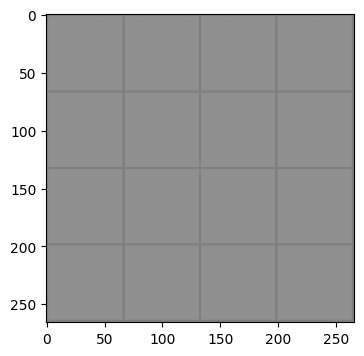

In [ ]:
# @title Sampling
import torchvision
import numpy as np
from matplotlib import pyplot as plt

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(4, 4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def reverse_flow(unet, cond, timesteps=25): # [n_samples, cond_dim]
    unet.eval()
    i = torch.linspace(0, 1, timesteps+1)
    # y = i # linear
    # y = LogitNormalCDF(i, mu=0, std=3.) # .5 _/- for std<1.8; 3 /-/ for std>1.8
    y = LogitNormalCDF(i, mu=-.0, std=2.7) # .5 _/- for std<1.8; 3 /-/ for std>1.8
    # y = Cosine(i) # _/-
    # y = ACosine(i) # /-/
    # y = Polynomial(i) # _/-
    # y = InvertCubic(i) # /-
    # y = InvertExp(i) # /-
    # y = bezier(i) # _/-

    dt = y[1:]-y[:-1]
    num_samples = cond.shape[0]
    x = torch.randn((num_samples, unet.in_ch, 16,16), device=device)
    # cond = cond.repeat(num_samples,1) # [n_samples, cond_dim]
    for y, dt in zip(y, dt):
        # print(y, dt)
        t = torch.full((num_samples,), y, device=device)  # Current time # [num_samples] 1. # torch.tensor(i * dt, device=device).repeat(n_samples)
        with torch.no_grad():
            model = lambda y,t: -unet(y, t, cond)
            v = model(x, t)
            x = x - dt * v # Euler update # 25steps:1sec

            # k1 = model(x, t)
            # k2 = model(x - 0.5 * dt * k1, t - 0.5 * dt)
            # k3 = model(x - 0.5 * dt * k2, t - 0.5 * dt)
            # k4 = model(x - dt * k3, t - dt)
            # x = x - (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4) # RK4 update # 25steps:4.5sec
    return x


# # cond = F.one_hot(torch.tensor([3]*16, device=device), num_classes=10).to(torch.float)
# cond = F.one_hot(torch.arange(16, device=device)%10, num_classes=10).to(torch.float)
# # img_ = reverse_flow(model, cond, timesteps=10)
# img_ = model.sample(cond)
# # # plt.imshow(img_.cpu().squeeze())
# # # plt.show()
# imshow(torchvision.utils.make_grid(img_.cpu(), nrow=4))


## main

In [ ]:
# @title conv deconv
import torch
import torch.nn as nn

class PixelAE(nn.Module):
    def __init__(self, in_ch=3, d_model=256, out_ch=None, kernels=[7,5], mult=[1]):
        super().__init__()
        if out_ch==None: out_ch = in_ch
        self.in_ch, self.d_model, self.out_ch = in_ch, d_model, out_ch
        d_list=[d_model*m for m in mult]
        in_list, out_list = [in_ch, *d_list[:-1]], [*d_list[:-1], out_ch]
        act = nn.GELU() # ReLU GELU SiLU
        self.encoder = nn.Sequential( # nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0), # SiLU ReLU
            # *[nn.Sequential(PixelShuffleConv(in_dim, out_dim, kernel, r=1/2), nn.BatchNorm2d(out_dim) if i!=len(d_list) else nn.Identity(), act,) for i, (in_dim, out_dim, kernel) in enumerate(zip(in_list, out_list, kernels))], # conv,norm,act except for last layer: no norm
            PixelShuffleConv(in_ch, d_list[0], 7, r=1/2), nn.BatchNorm2d(d_list[0]), act,
            PixelShuffleConv(d_list[0], out_ch, 5, r=1/2), act,
        )
            # ResBlock(in_ch, out_ch, emb_dim=emb_dim),
            # AttentionBlock(out_ch, d_head, cond_dim),
        # nn.init.zeros_(self.encoder.parameters()[-1])
        # self.encoder[-2].apply(self.zero_conv_)

        self.decoder = nn.Sequential(
            # *[nn.Sequential(PixelShuffleConv(in_dim, out_dim, kernel, r=2), nn.BatchNorm2d(out_dim) if i!=len(d_list) else nn.Identity(), act if i!=len(d_list) else nn.Identity()) for i, (in_dim, out_dim, kernel) in enumerate(zip(reversed(out_list), reversed(in_list), reversed(kernels)))], # conv,norm,act except for last layer: only conv
            # *[nn.Sequential(PixelShuffleConv(in_dim, out_dim, kernel, r=2), *(nn.BatchNorm2d(out_dim), act) if i!=len(d_list) else nn.Identity()) for i, (in_dim, out_dim, kernel) in enumerate(zip(reversed(out_list), reversed(in_list), reversed(kernels)))], # conv,norm,act except for last layer: only conv
            PixelShuffleConv(out_ch, d_list[0], 5, r=2), nn.BatchNorm2d(d_list[0]), act,
            PixelShuffleConv(d_list[0], in_ch, 7, r=2),
        )
        # for param in self.parameters():
        # nn.init.zeros_(self.decoder.parameters()[-1])
    #     self.decoder[-1].apply(self.zero_conv_)

    # def zero_conv_(self, conv): # weight initialisation very important for the performance of pixelshuffle!
    #     if isinstance(conv, nn.Conv2d):
    #         nn.init.zeros_(conv.bias.data)


    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x
    def encode(self, x): return self.encoder(x)
    def decode(self, x): return self.decoder(x)


# in_ch=3
# model_ch=16
# d_list=[16, 16] # [16,32]
# k_list=[7,5] # [7,5]

# device = "cuda" if torch.cuda.is_available() else "cpu"
# model = PixelAE(in_ch=in_ch, d_list=d_list, k_list=k_list) # ReLU GELU SiLU
# print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 19683
# input = torch.rand((4,in_ch,64,64), device=device)
# enc = model.encode(input)
# print(enc.shape)
# out = model.decode(enc)
# print(out.shape)


In [ ]:
model = PixelAE()
# nn.init.zeros_(model.decoder.parameters()[-1])
# print(model.decoder.parameters())
# print(model.decoder[-2])
# nn.init.zeros_(model.decoder[-2])
# model.decoder[-2].apply(nn.init.zeros_)

def init_conv_(conv): # weight initialisation very important for the performance of pixelshuffle!
    if isinstance(conv, nn.Conv2d):
        nn.init.zeros_(conv.bias.data)

model.decoder[-2].apply(init_conv_)




PixelShuffleConv(
  (net): Sequential(
    (0): Conv2d(256, 12, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): PixelShuffle(upscale_factor=2)
  )
)

In [ ]:
# @title latent flow model

class LFM(nn.Module): # latent flow model
    def __init__(self, in_ch=3, d_list=[16, 3], d_model=16, cond_dim=16, depth=3, ae=None):
        super().__init__()
        self.ae = ae or PixelAE(in_ch, d_model)
        self.unet = UNet(in_ch=in_ch, d_model=d_model, cond_dim=cond_dim, depth=3)

    def loss(self, img, cond): # [b,c,h,w], [b,cond_dim]
        x1 = self.ae.encode(img)
        img_ = self.ae.decode(x1)
        ae_loss = F.mse_loss(img_, img)
        fm_loss = otfm_loss(self.unet, x1.detach(), cond)
        return ae_loss, fm_loss
        # loss = ae_loss + fm_loss
        # return loss

    def ae_loss(self, img):
        img_ = self.ae(img)
        ae_loss = F.mse_loss(img_, img)
        return ae_loss


    # self.unet(x, t=None, cond=None)
    # def forward(self, cond, timesteps=10): # [N, C, ...]
    def sample(self, cond=None, timesteps=10):
        self.eval()
        # cond = F.one_hot(torch.tensor([4], device=device), num_classes=10).to(torch.float)
        # if cond is None: cond = F.one_hot(torch.arange(n_samples, dtype=torch.float, device=device)%10, num_classes=10).to(torch.float)
        n_samples = cond.shape[0]

        with torch.no_grad():
            x1_ = reverse_flow(self.unet, cond, n_samples, timesteps=timesteps)
            img_ = self.ae.decode(x1_)
        return img_

model = LFM(d_list=[16, 16], d_model=16, cond_dim=10, depth=3).to(device)
# model = LFM(ae=model.ae, d_list=[16, 16], d_model=16, cond_dim=10, depth=3).to(device)
optim = torch.optim.AdamW(model.parameters(), lr=3e-3) # 1e-3 3e-3


0 0.8394656181335449


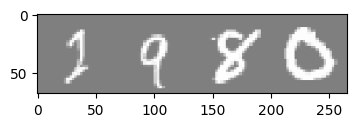

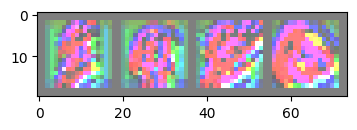

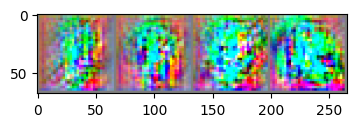

10 0.11558197438716888
20 0.06201299652457237
30 0.04349052533507347
40 0.034285768866539
50 0.02890915796160698
60 0.025643428787589073
70 0.022917136549949646
80 0.020689036697149277
90 0.01915699802339077
100 0.017870783805847168
110 0.016281284391880035


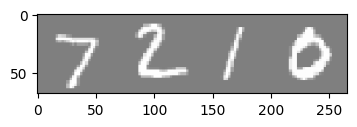

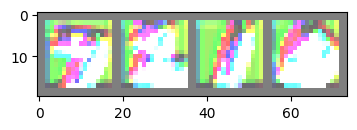

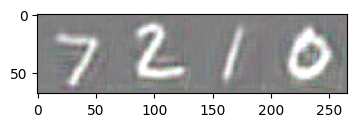

0 0.015835585072636604


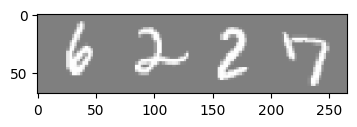

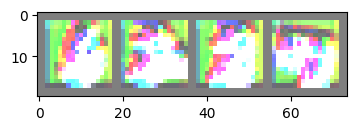

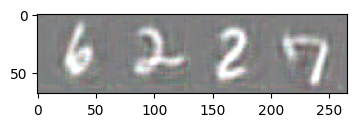

10 0.01485027652233839
20 0.014606914483010769
30 0.01396738551557064
40 0.013212095946073532
50 0.013022440485656261
60 0.01291145384311676
70 0.012548796832561493
80 0.011793991550803185
90 0.011673510074615479
100 0.011850465089082718
110 0.011624108999967575


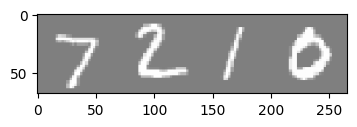

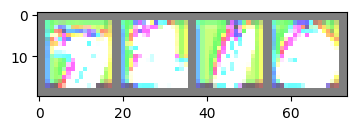

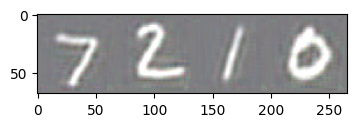

0 0.011476079933345318


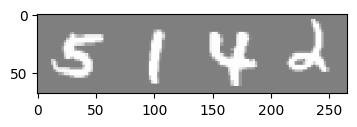

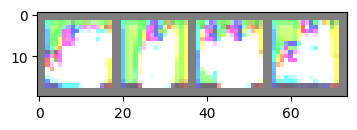

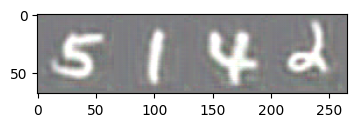

10 0.01099449209868908
20 0.010787896811962128
30 0.010579917579889297
40 0.010705238208174706
50 0.010474076494574547
60 0.010305359028279781
70 0.010352090001106262
80 0.010482332669198513
90 0.009925039485096931
100 0.010040435008704662
110 0.009762277826666832


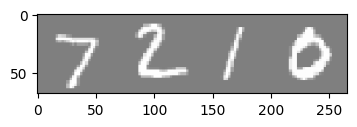

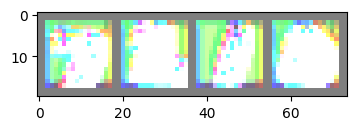

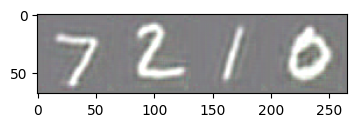

0 0.009738020598888397


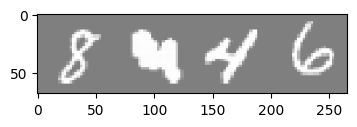

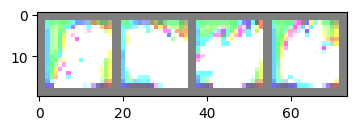

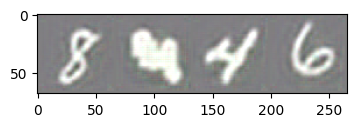

10 0.010232018306851387
20 0.009748980402946472
30 0.009205500595271587
40 0.00938391499221325
50 0.00924600474536419
60 0.009163795039057732
70 0.009130849502980709
80 0.00899026170372963
90 0.009032968431711197
100 0.008974526077508926
110 0.008823489770293236


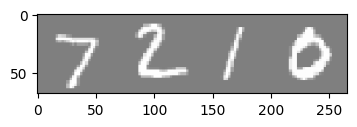

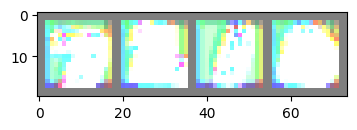

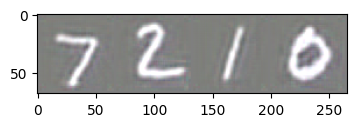

0 0.009110219776630402


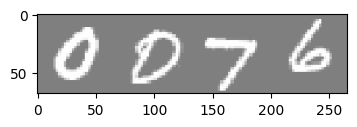

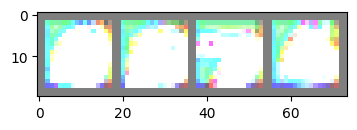

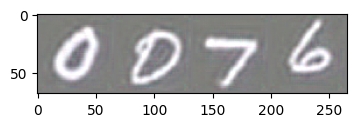

10 0.008627858944237232
20 0.008655047044157982
30 0.0087004778906703
40 0.00837431475520134
50 0.008795702829957008
60 0.008582650683820248
70 0.008306938223540783
80 0.008412225171923637
90 0.008227260783314705
100 0.008295437321066856
110 0.008241317234933376


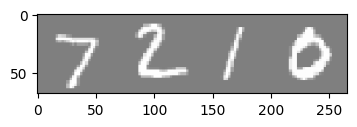

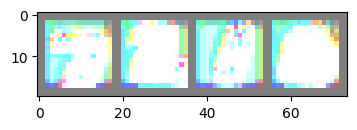

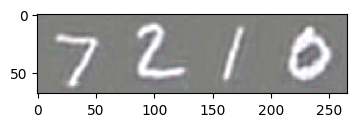

0 0.008375383913516998


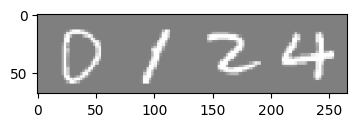

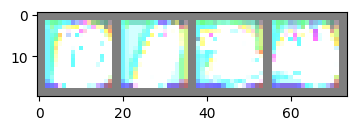

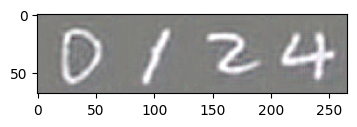

10 0.008199541829526424
20 0.008000856265425682
30 0.007928677834570408
40 0.007968127727508545
50 0.007794538047164679
60 0.007896778173744678
70 0.00807660911232233
80 0.007550886832177639
90 0.007844576612114906
100 0.007705740164965391
110 0.0077319396659731865


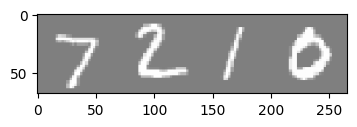

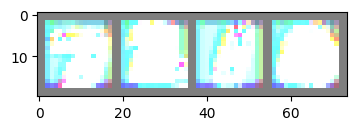

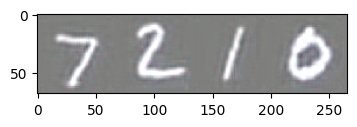

0 0.00792476162314415


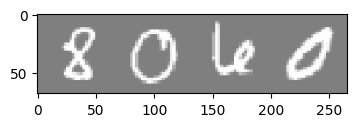

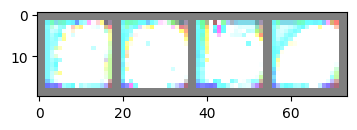

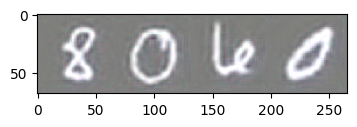

10 0.008057988248765469
20 0.007692024111747742
30 0.007595151662826538
40 0.007477369159460068
50 0.007559766061604023
60 0.00727576669305563
70 0.0072791120037436485
80 0.007181146182119846
90 0.007218792103230953
100 0.007017785683274269
110 0.007544239517301321


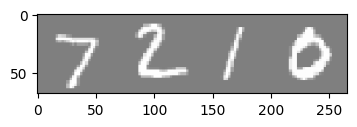

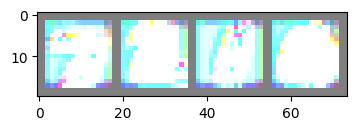

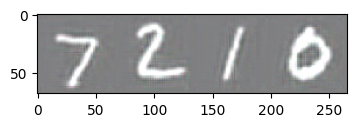

0 0.008077964186668396


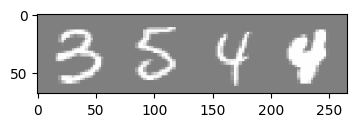

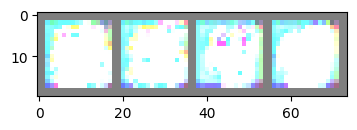

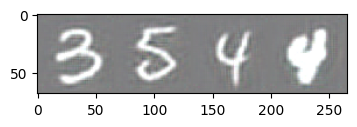

10 0.007145445793867111
20 0.006756440736353397
30 0.006803300231695175
40 0.006660677492618561
50 0.006951989606022835
60 0.006833861581981182
70 0.006806383840739727
80 0.006576844956725836
90 0.006627440452575684
100 0.006694329436868429
110 0.006699416786432266


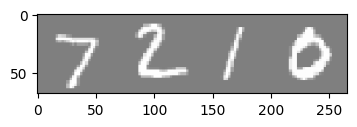

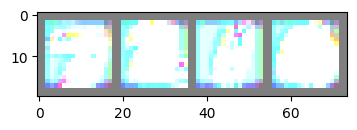

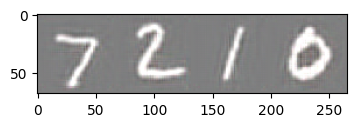

0 0.006479829549789429


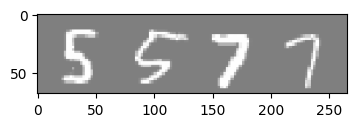

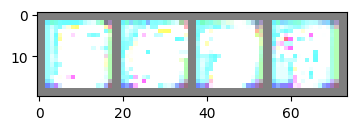

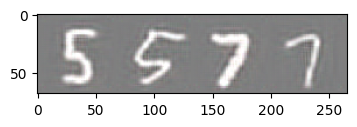

10 0.006620690226554871
20 0.006322496570646763
30 0.00625700643286109
40 0.006249552592635155
50 0.006169870495796204
60 0.006159374024719
70 0.006157981231808662
80 0.006214987486600876
90 0.006030131131410599
100 0.006131372414529324
110 0.006000571884214878


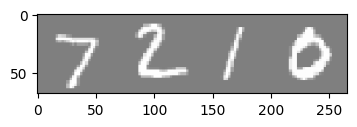

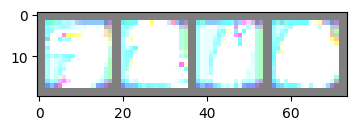

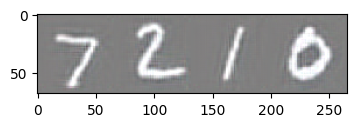

0 0.0061541153118014336


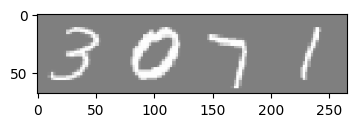

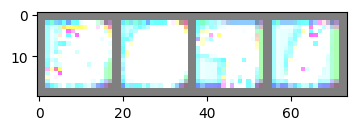

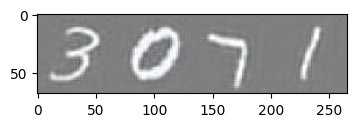

10 0.006117329001426697
20 0.006809301674365997
30 0.006779924035072327
40 0.005677703768014908
50 0.00590326264500618
60 0.005583722144365311
70 0.00593172200024128
80 0.005965168587863445
90 0.005914479494094849
100 0.005787977483123541
110 0.006300000008195639


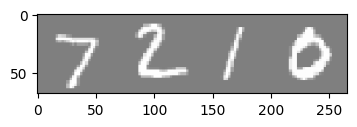

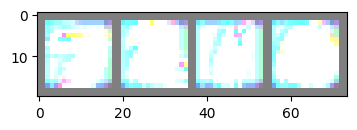

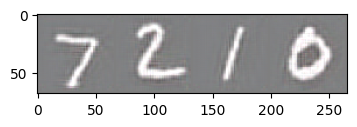

0 0.006435479503124952


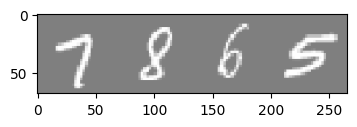

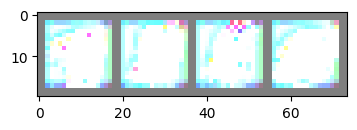

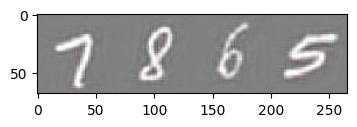

10 0.005761176347732544
20 0.005558814853429794
30 0.005899759009480476
40 0.005431624129414558
50 0.005302197299897671
60 0.005438120570033789
70 0.005379009526222944
80 0.006076506804674864
90 0.0053479610942304134
100 0.005436343140900135
110 0.006151433568447828


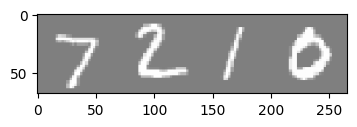

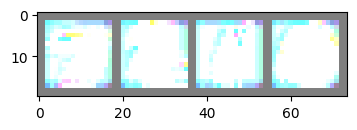

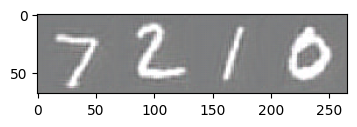

0 0.0054928152821958065


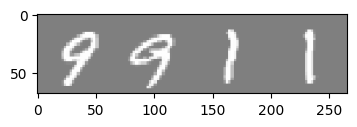

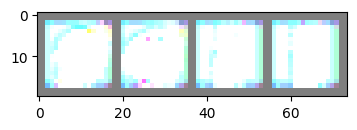

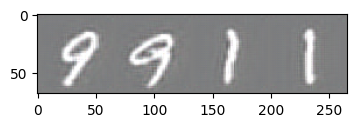

10 0.0051047662273049355
20 0.005372987128794193
30 0.005103380884975195
40 0.00526089733466506
50 0.005263998173177242
60 0.0053730253130197525
70 0.00501596461981535
80 0.005192261189222336
90 0.0052764443680644035
100 0.004871871322393417
110 0.004842434078454971


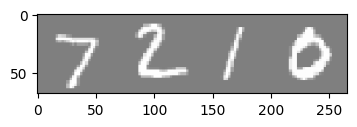

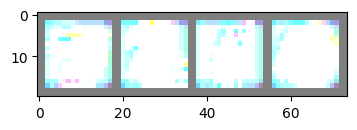

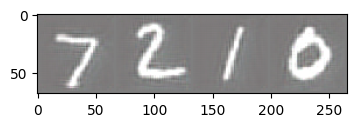

0 0.005724170710891485


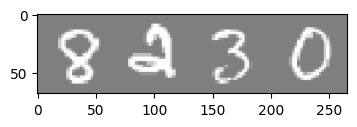

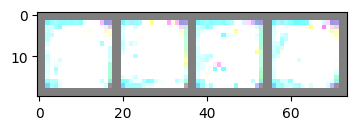

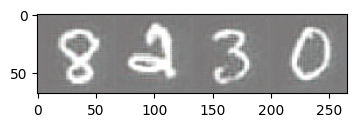

10 0.005374676547944546
20 0.004771566018462181
30 0.0049790749326348305
40 0.004894719924777746
50 0.004698329139500856
60 0.004668160807341337
70 0.0047519332729279995
80 0.005502224899828434
90 0.004635216202586889
100 0.00457377266138792
110 0.0045776572078466415


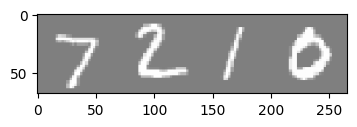

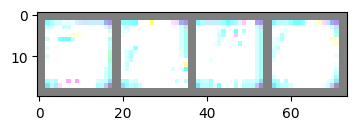

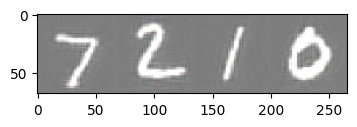

0 0.0055283308029174805


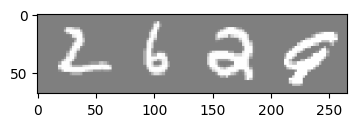

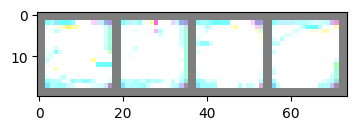

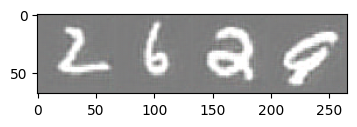

10 0.00466042710468173
20 0.00557809229940176
30 0.004632655531167984
40 0.004757057409733534
50 0.0046683670952916145
60 0.004449114203453064
70 0.004555084742605686
80 0.004513619467616081
90 0.004346413537859917
100 0.0043597761541605
110 0.004663629923015833


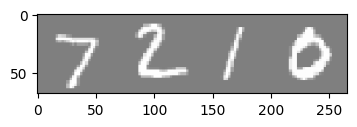

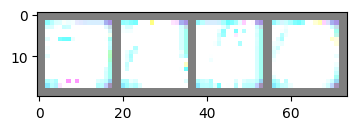

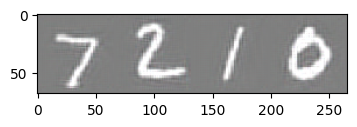

0 0.004393165931105614


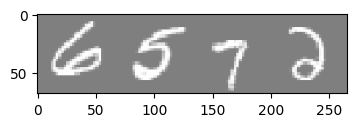

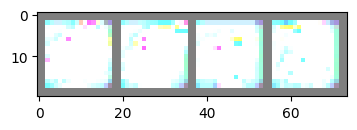

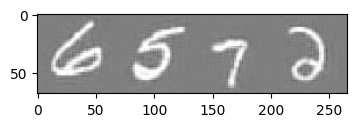

10 0.004418599884957075
20 0.005133352242410183
30 0.004523230250924826
40 0.004397361073642969
50 0.004311800003051758
60 0.005031822249293327
70 0.004250985570251942
80 0.004179590381681919
90 0.00433983514085412
100 0.004183265846222639
110 0.004184525925666094


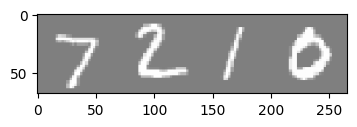

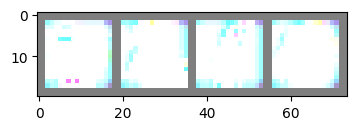

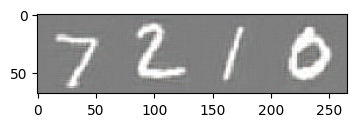

0 0.004409301094710827


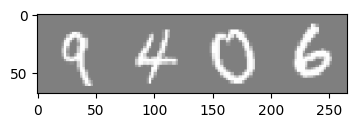

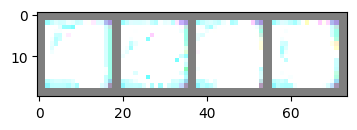

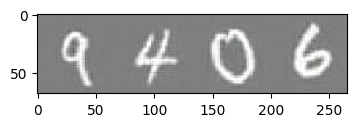

10 0.004570001736283302
20 0.0043281568214297295
30 0.004141352139413357
40 0.0041058543138206005
50 0.004759625531733036
60 0.004412313457578421
70 0.004131751600652933
80 0.004287316929548979
90 0.0040621585212647915
100 0.003998011350631714
110 0.003941476345062256


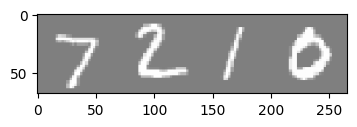

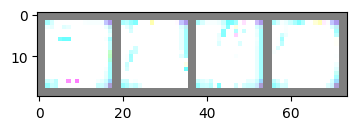

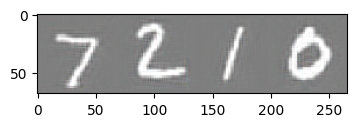

0 0.0040318649262189865


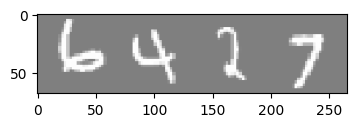

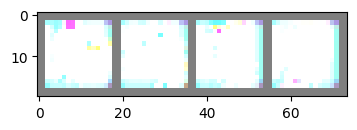

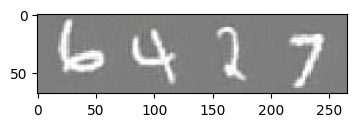

10 0.004084949381649494
20 0.004429389722645283
30 0.004171821754425764
40 0.003943582996726036
50 0.004310736898332834
60 0.003871749620884657
70 0.0039067342877388
80 0.0040023066103458405
90 0.004239722620695829
100 0.003976300824433565
110 0.003849632106721401


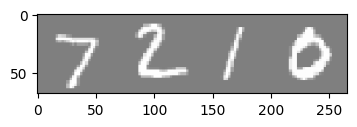

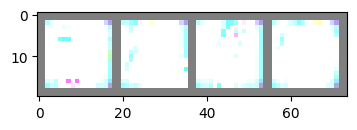

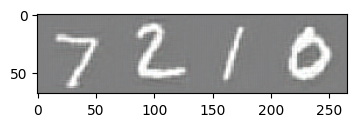

0 0.004556526895612478


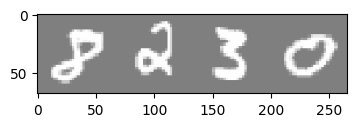

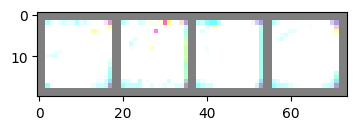

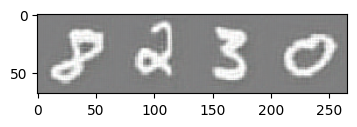

10 0.004272621590644121
20 0.003858577460050583
30 0.003827786771580577
40 0.0038257478736341
50 0.003983065485954285
60 0.0038362666964530945
70 0.0038726734928786755
80 0.004071427043527365
90 0.0039563290774822235
100 0.003999641165137291
110 0.004230810329318047


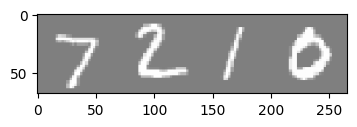

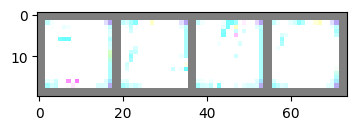

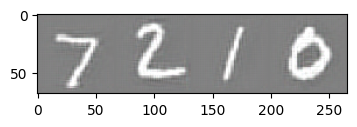

0 0.004045303910970688


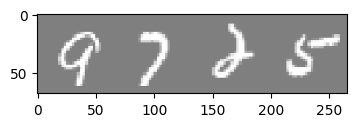

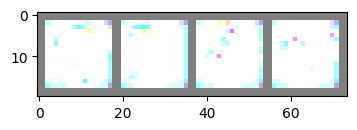

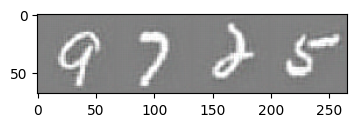

10 0.0038480176590383053
20 0.0039107827469706535
30 0.003950468730181456
40 0.0038763273041695356
50 0.0038453785236924887
60 0.0036847672890871763
70 0.003651598934084177
80 0.0036928970366716385
90 0.0036401175893843174
100 0.0037408757489174604
110 0.0037219165824353695


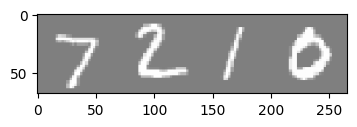

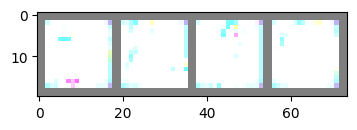

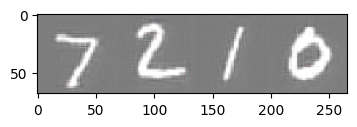

0 0.004181310534477234


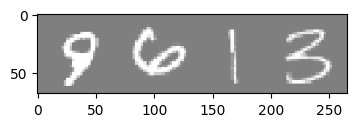

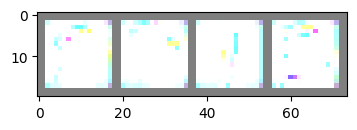

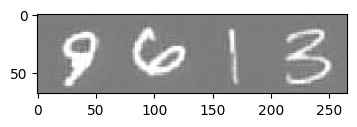

10 0.004023851826786995
20 0.0044720787554979324
30 0.004229228477925062
40 0.003734403057023883
50 0.0036416545044630766
60 0.0035899928770959377
70 0.0036712621804326773
80 0.003641167189925909
90 0.004082913976162672
100 0.003845467697829008
110 0.0038916319608688354


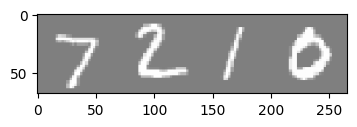

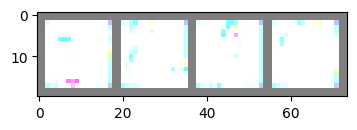

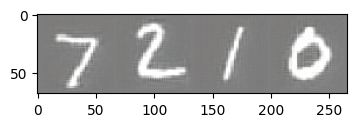

0 0.0045448532328009605


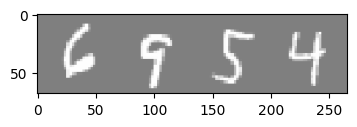

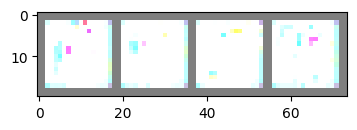

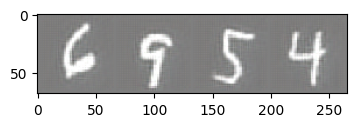

10 0.003937884699553251
20 0.003596032038331032
30 0.0036866473965346813
40 0.003592850174754858
50 0.0040643224492669106
60 0.003651007078588009
70 0.0037628530990332365
80 0.0037072347477078438
90 0.003843992715701461
100 0.0038998182862997055
110 0.003475844394415617


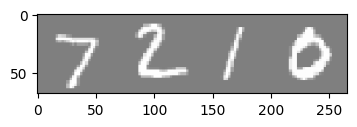

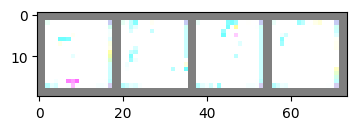

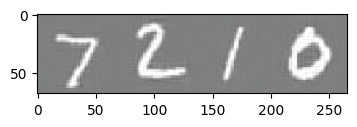

0 0.0038937130011618137


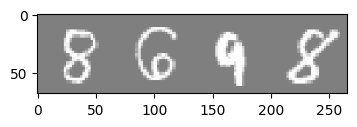

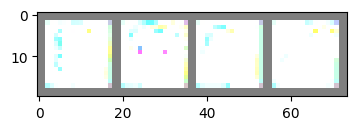

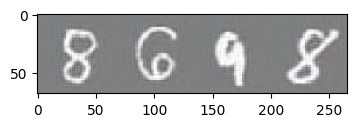

10 0.0034135389141738415
20 0.003437172621488571
30 0.0033961317967623472
40 0.0037858716677874327
50 0.003536086529493332
60 0.00342472898773849
70 0.003385472111403942
80 0.0034494732972234488
90 0.0035269418731331825
100 0.0035095512866973877
110 0.003454664722084999


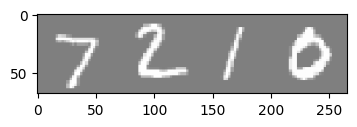

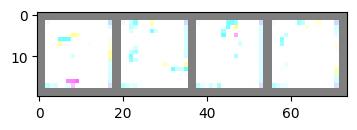

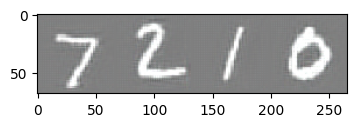

0 0.003678879700601101


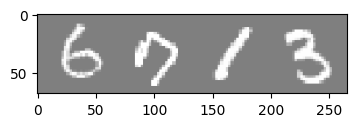

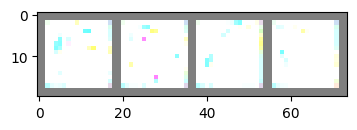

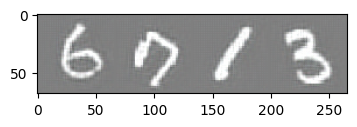

10 0.0034896857105195522
20 0.003565299091860652
30 0.003411058336496353
40 0.003773121163249016
50 0.003586539998650551
60 0.003344097640365362
70 0.0036489819176495075
80 0.0034189920406788588
90 0.0034668543376028538
100 0.003556727897375822
110 0.0033650496043264866


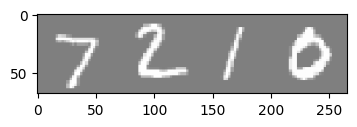

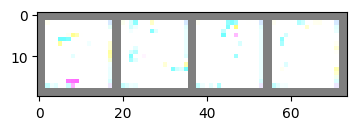

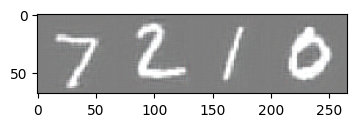

0 0.0033727872651070356


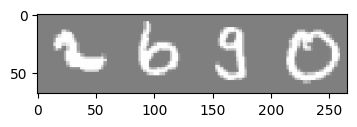

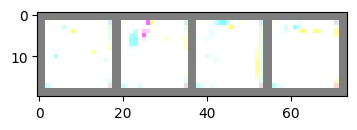

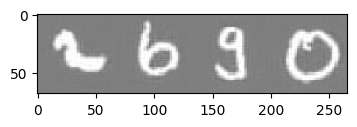

10 0.0037247135769575834
20 0.003321003634482622
30 0.0033121209125965834
40 0.0033859722316265106
50 0.0033997311256825924
60 0.003310514148324728
70 0.0033954959362745285
80 0.0034820139408111572
90 0.0035081002861261368
100 0.0034798812121152878
110 0.0031960131600499153


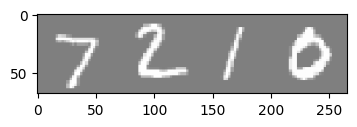

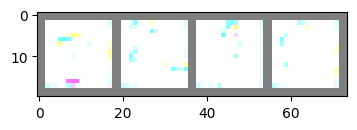

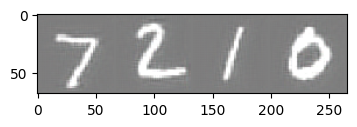

0 0.004338896833360195


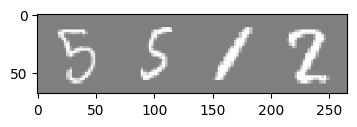

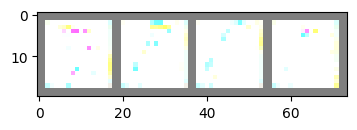

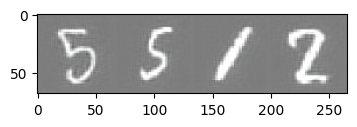

10 0.0036334895994514227
20 0.0035318515729159117
30 0.003510633483529091
40 0.0031487341038882732
50 0.0032377734314650297
60 0.0034618000499904156
70 0.0033422799315303564
80 0.0034822802990674973
90 0.0033078952692449093
100 0.0031975717283785343
110 0.003102394752204418


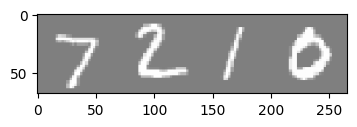

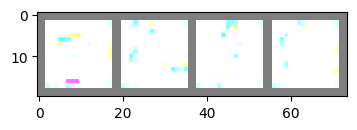

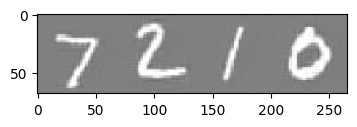

0 0.003094751387834549


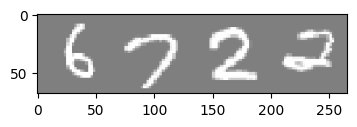

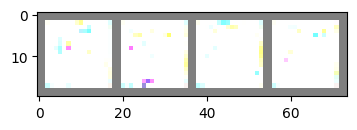

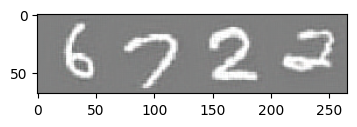

10 0.003226097673177719
20 0.0031852959655225277
30 0.003385331016033888
40 0.003123332280665636


In [ ]:
# @title train
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
scaler = torch.GradScaler(device)

def otfm_loss(model, x1, cond, sig_min = 0.001, eps = 1e-5): # UNetModel, [b,c,h,w], [b,cond_dim] # https://github.com/lebellig/flow-matching/blob/main/Flow_Matching.ipynb
    batch = x1.size(0)
    # t = torch.rand((batch,), device=device) % (1 - eps)
    t = logit_normal.rsample((batch,)).to(device) # in [0,1] [batch,1]
    t_ = t[...,None,None,None]
    x0 = torch.randn_like(x1)
    psi_t = (1 - (1-sig_min)*t_)*x0 + t_*x1 # ψt(x) = (1 − (1 − σmin)t)x + tx1, (22)
    v_psi = model(psi_t, t, cond) # vt(ψt(x0))
    d_psi = x1 - (1 - sig_min) * x0 #
    return F.mse_loss(v_psi, d_psi) # LCFM(θ)


def train(model, optim, dataloader):
    model.train()
    for i, (x1, y) in enumerate(dataloader):
        x1, y = x1.to(device), y.to(device)
        # cond = cond_emb(y)
        cond = F.one_hot(y, num_classes=10).to(torch.float)

        with torch.autocast(device_type=device, dtype=torch.bfloat16): # float16 cannot?
            # x1 = F.interpolate(x1, size=(16,16)).repeat(1,3,1,1)
            # loss = otfm_loss(model, x1, cond) # unet
            img = F.interpolate(x1, size=(64,64)).repeat(1,3,1,1)
            # loss = model.ae_loss(img)
            # ae_loss, fm_loss = model.loss(x1, cond)

            x1 = model.ae.encode(img)
            img_ = model.ae.decode(x1)
            ae_loss = F.mse_loss(img_, img)

            # with torch.no_grad(): x1 = model.ae.encode(img)
            # fm_loss = otfm_loss(model.unet, x1.detach(), cond)

            loss = ae_loss #+ fm_loss

        scaler.scale(loss).backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # clip gradients
        scaler.step(optim)
        scaler.update()

        if i % 10 == 0:
            print(i,loss.item())
            # print(i,ae_loss.item(), fm_loss.item())
        if i % 200 == 0:
            imshow(torchvision.utils.make_grid(img[:4].detach().cpu().to(torch.float32), nrow=4))
            imshow(torchvision.utils.make_grid(x1[:4].detach().cpu().to(torch.float32), nrow=4))
            imshow(torchvision.utils.make_grid(img_[:4].detach().cpu().to(torch.float32), nrow=4))

            # cond = F.one_hot(torch.arange(16, device=device)%10, num_classes=10).to(torch.float)
            # # img_ = reverse_flow(model, cond, timesteps=10) # unet
            # img_ = model.sample(cond, timesteps=10) # ldm
            # imshow(torchvision.utils.make_grid(img_.cpu(), nrow=4))

        try: wandb.log({"loss": loss.item()})
        # try: wandb.log({"ae_loss": ae_loss.item(), "fm_loss": fm_loss.item()})
        except: pass

# for epoch in range(1):
for epoch in range(40):
    train(model, optim, train_loader)

    for x,y in test_loader: break
    img = F.interpolate(x.to(device), size=(64,64)).repeat(1,3,1,1)
    x1 = model.ae.encode(img)
    img_ = model.ae.decode(x1)
    imshow(torchvision.utils.make_grid(img[:4].detach().cpu().to(torch.float32), nrow=4))
    imshow(torchvision.utils.make_grid(x1[:4].detach().cpu().to(torch.float32), nrow=4))
    imshow(torchvision.utils.make_grid(img_[:4].detach().cpu().to(torch.float32), nrow=4))

    # # # cond = F.one_hot(torch.tensor([4], device=device), num_classes=10).expand(16,-1).to(torch.float)
    # cond = F.one_hot(torch.arange(16, device=device)%10, num_classes=10).to(torch.float)
    # # img_ = reverse_flow(model, cond, timesteps=10) # unet
    # img_ = model.sample(cond, timesteps=10) # ldm
    # imshow(torchvision.utils.make_grid(img_.cpu(), nrow=4))


In [ ]:
# @title test func

def test(model, dataloader):
    model.eval()
    total_loss=0
    for i, (x1, y) in enumerate(dataloader):
        x1, y = x1.to(device), y.to(device)
        # cond = cond_emb(y)
        cond = F.one_hot(y, num_classes=10).to(torch.float)

        with torch.autocast(device_type=device, dtype=torch.bfloat16): # float16 cannot?
            # x1 = F.interpolate(x1, size=(64,64)).repeat(1,3,1,1)
            # ae_loss, fm_loss = model.loss(x1, cond)
            # loss = ae_loss + fm_loss
            x1 = F.interpolate(x1, size=(16,16))#.repeat(1,3,1,1)
            loss = otfm_loss(model, x1, cond) # unet
        total_loss+=loss
    print(total_loss/len(dataloader))
    # if i % 10 == 0: print(i,ae_loss.item(),fm_loss.item())
    try: wandb.log({"test_loss": loss.item()})
    # try: wandb.log({"ae_loss": ae_loss.item(), "fm_loss": fm_loss.item()})
    except: pass


# test(model, test_loader)


In [ ]:
# @title wandb
!pip install -q wandb
import wandb # https://docs.wandb.ai/quickstart
wandb.login(key='487a2109e55dce4e13fc70681781de9f50f27be7')
try: run.finish()
except NameError: pass
run = wandb.init(project="lfm", config={"model": "res18",})

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: bobdole to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
# @title save/load
from google.colab import drive
drive.mount('/content/drive')
folder='/content/drive/MyDrive/jepa/'

# modelsd, optimsd = torch.load(folder+'lfm.pkl', map_location=device).values()
# model.load_state_dict(modelsd, strict=False)
# optim.load_state_dict(optimsd)

Mounted at /content/drive


In [ ]:
checkpoint = {'model': model.state_dict(), 'optimizer': optim.state_dict()}
torch.save(checkpoint, folder+'lfm_ae.pkl')

In [ ]:

# High Fidelity Visualization of What Your Self-Supervised Representation Knows About aug 2022
# https://arxiv.org/pdf/2112.09164




torch.Size([128, 3, 64, 64])


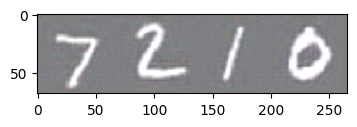

In [ ]:
# # dataiter = iter(train_data)
# x,y = next(dataiter)
# # print(x)
# print(x.shape)
# x=x.unsqueeze(0)
# # x1 = F.interpolate(x, size=(16,16))#.repeat(1,3,1,1)
# x1 = F.interpolate(x, size=(64,64)).repeat(1,3,1,1)
# imshow(torchvision.utils.make_grid(x1.cpu(), nrow=4))

## save

In [ ]:
# @title unet me
import torch
import torch.nn as nn
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"
# torch.set_default_dtype(torch.float16)

import inspect
class Seq(nn.Sequential):
    def __init__(self, *args):
        super().__init__(*args)
        for layer in self:
            params = inspect.signature(layer.forward).parameters.keys()
            layer._fwdparams = ','.join(params)

    def forward(self, x, emb=None, cond=None):
        for layer in self:
            args = [x]
            if 'emb' in layer._fwdparams: args.append(emb)
            if 'cond' in layer._fwdparams: args.append(cond)
            x = layer(*args)
        return x

class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch=None, emb_dim=None, drop=0.):
        super().__init__()
        if out_ch==None: out_ch=in_ch
        act = nn.SiLU() #
        self.block1 = nn.Sequential(nn.BatchNorm2d(in_ch), act, nn.Conv2d(in_ch, out_ch, 3, padding=1))
        self.block2 = Seq(nn.BatchNorm2d(out_ch), scale_shift(out_ch, emb_dim) if emb_dim != None else nn.Identity(), act, nn.Conv2d(out_ch, out_ch, 3, padding=1))
        self.res_conv = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, emb=None): # [b,c,h,w], [batch, emb_dim]
        h = self.block1(x)
        h = self.block2(h, emb)
        return h + self.res_conv(x)

class scale_shift(nn.Module): # FiLM
    def __init__(self, x_dim, t_dim):
        super().__init__()
        self.time_mlp = nn.Sequential(nn.SiLU(), nn.Linear(t_dim, x_dim*2),)

    def forward(self, x, emb): # [b,c,h,w], [b,emb_dim]
        scale, shift = self.time_mlp(emb)[..., None, None].chunk(2, dim=1) # [b,t_dim]->[b,2*x_dim,1,1]->[b,x_dim,1,1]
        return x * (scale + 1) + shift

class levelBlock(nn.Module):
    def __init__(self, in_ch, out_ch, emb_dim, cond_dim, n_head=None, d_head=8, updown=False, r=2):
        super().__init__()
        if updown=='down': in_ch = in_ch*r**2
        elif updown=='up': out_ch = out_ch*r**2
        if n_head==None: n_head = out_ch // d_head
        layers = [
            nn.PixelUnshuffle(r) if updown=='down' else nn.Identity(),
            ResBlock(in_ch, out_ch, emb_dim=emb_dim),
            AttentionBlock(out_ch, d_head, cond_dim),
            nn.PixelShuffle(r) if updown=='up' else nn.Identity(),
            ]
        self.seq = Seq(*layers)

    def forward(self, x, emb=None, cond=None):
        return self.seq(x, emb, cond)


class UNet(nn.Module):
    def __init__(self, in_ch=3, d_model=16, out_ch=None, cond_dim=16, depth=4, num_res_blocks=1, n_head=-1, d_head = 4):
        super().__init__()
        self.in_ch = in_ch
        self.d_model = d_model # base channel count for the model
        out_ch = out_ch or in_ch
        n_head = d_model // d_head

        self.rotemb = RotEmb(d_model)
        emb_dim = d_model# * 4
        self.time_emb = nn.Sequential(nn.Linear(d_model, emb_dim), nn.SiLU(), nn.Linear(emb_dim, emb_dim))


        tok_dim = d_model
        # if tok_dim == None: tok_dim = d_model
        self.num_time_tokens = 2
        self.time_mlp = nn.Sequential(
            RotEmb(emb_dim, top=torch.pi, base=10000),
            nn.Linear(emb_dim, emb_dim), nn.SiLU(),
            nn.Linear(emb_dim, emb_dim + self.num_time_tokens * tok_dim),
        )
        self.emb_dim, self.tok_dim = emb_dim, tok_dim
        self.cond_mlp = nn.Sequential(
            nn.LayerNorm(cond_dim), nn.Linear(cond_dim, emb_dim), nn.SiLU(),
            nn.Linear(emb_dim, emb_dim + tok_dim)
        )
        self.norm_cond = nn.LayerNorm(tok_dim)
        cond_dim = tok_dim


        self.in_block = nn.Sequential(nn.Conv2d(in_ch, d_model, 3, padding=1))
        # self.in_block = nn.Sequential(nn.Conv2d(in_ch, d_model, 3, padding=1), act)
        # self.init_conv = CrossEmbedLayer(in_ch, dim_out=d_model, kernel_sizes=(3, 7, 15), stride=1) #if init_cross_embed else nn.Conv2d(in_ch, d_model, 7, padding = 7//2)

        dim_mults = [1,2,3,4,4] # [1,2,3,4] [1,2,2,2]
        ch_list = [d_model * m for m in dim_mults] # [128, 256, 384, 512]
        # in_out = list(zip(dims[:-1], dims[1:]))
        # for ind, (dim_in, dim_out) in enumerate(in_out):


        self.down_list = nn.ModuleList([levelBlock(ch_list[i], ch_list[i+1], emb_dim, cond_dim, updown=None if i==0 else 'down') for i in range(depth)])
        # self.down_list = nn.ModuleList([levelBlock(ch_list[i], ch_list[i+1], emb_dim, cond_dim, updown='down') for i in range(depth)])

        ch = ch_list[-1]*2**2 # 512
        self.middle_block = Seq(
            nn.PixelUnshuffle(2), ResBlock(ch, ch, emb_dim),
            AttentionBlock(ch, d_head, cond_dim),
            ResBlock(ch, ch, emb_dim), nn.PixelShuffle(2),
        )
        self.up_list = nn.ModuleList([levelBlock(2*ch_list[i+1], ch_list[i], emb_dim, cond_dim, updown=None if i==0 else 'up') for i in reversed(range(depth))])
        # self.up_list = nn.ModuleList([levelBlock(2*ch_list[i+1], ch_list[i], emb_dim, cond_dim, updown='up') for i in reversed(range(depth))])
        # for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):

        self.out_block = nn.Sequential(nn.BatchNorm2d(d_model), nn.SiLU(), nn.Conv2d(d_model, out_ch, 3, padding=1)) # zero
        # self.final_conv = nn.Conv2d(d_model, self.out_ch, 3, padding = 3//2) # lucid; or prepend final res block

    def forward(self, x, t=None, cond=None): # [N, c,h,w], [N], [N, cond_dim]
        # t_emb = self.rotemb(t)
        # emb = self.time_emb(t_emb) #+ self.label_emb(y) # class conditioning nn.Embedding(num_classes, emb_dim)





        t_hid, t_tok = self.time_mlp(t).split([self.emb_dim, self.num_time_tokens * self.tok_dim], dim=-1)
        t_tok = t_tok.reshape(t_tok.shape[0], self.num_time_tokens, self.tok_dim)
        c_hid, c_tok = self.cond_mlp(cond).split([self.emb_dim, self.tok_dim], dim=-1)
        # print('unet fwd', t_hid.shape, t_tok.shape, t.shape)

        emb = t_hid + c_hid # [batch, emb_dim]
        cond = torch.cat((t_tok, c_tok.unsqueeze(1)), dim=-2) # [b, num_toks, tok_dim]
        cond = self.norm_cond(cond)




        blocks = []
        x = self.in_block(x)
        for i, down in enumerate(self.down_list):
            x = down(x, emb, cond)
            blocks.append(x)
        x = self.middle_block(x, emb, cond)
        for i, up in enumerate(self.up_list):
            # print("unet fwd", x.shape,blocks[-i-1].shape)
            x = torch.cat([x, blocks[-i-1]*2**.5], dim=1) # scale residuals by 1/sqrt2
            x = up(x, emb, cond) # x = up(x, blocks[-i - 1])
        return self.out_block(x)



# 64,64 -vae-> 16,16 -unet->
batch = 4
cond_dim=10
model = UNet(in_ch=1, d_model=16, cond_dim=cond_dim, depth=3).to(device)
print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 19683
# print(model)

# x=torch.rand((batch,3,16,16),device=device)
x=torch.rand((batch,1,16,16),device=device)
# y=torch.rand((batch,1,16,16),device=device)
t = torch.rand((batch,), device=device) # in [0,1] [N]
# print(t)
cond=torch.rand((batch,cond_dim),device=device)
# [2, 1, 16, 16]) torch.Size([2]) torch.Size([2, 10]
print(x.shape,t.shape,cond.shape)
out = model(x, t, cond)
print(out.shape)

optim = torch.optim.AdamW(model.parameters(), lr=1e-3) # 1e-3 3e-3

cond_emb = nn.Embedding(10, cond_dim).to(device)
# for name, param in model.named_parameters(): print(name, param)
# optim.zero_grad()
# loss = F.mse_loss(out, y)
# loss.backward()
# optim.step()

5323509
torch.Size([4, 1, 16, 16]) torch.Size([4]) torch.Size([4, 10])
torch.Size([4, 1, 16, 16])


In [ ]:
# @title conv deconv
import torch
import torch.nn as nn

class Conv(nn.Module):
    def __init__(self, in_ch=3, d_list=[32, 64], k_list=[7,5], act=nn.GELU(), drop=0.): # ReLU GELU SiLU
        super().__init__()
        self.conv = nn.Sequential( # nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0), # SiLU ReLU
            PixelShuffleConv(in_ch, d_list[0], k_list[0], r=1/2), nn.BatchNorm2d(d_list[0]), act,
            nn.Dropout2d(drop), PixelShuffleConv(d_list[0], d_list[1], k_list[1], r=1/2), act,
        )
    def forward(self, x): return self.conv(x) # [batch, 3,64,64] -> [batch, c,h,w]

class Deconv(nn.Module):
    def __init__(self, out_ch=3, d_list=[32, 64], k_list=[7,5], act=nn.GELU(), drop=0.): # ReLU GELU SiLU
        super().__init__()
        self.deconv = nn.Sequential(
            PixelShuffleConv(d_list[1], d_list[0], k_list[1], r=2), nn.BatchNorm2d(d_list[0]), act,
            PixelShuffleConv(d_list[0], out_ch, k_list[0], r=2),
        )
    def forward(self, x): return self.deconv(x) # [batch, c,h,w] -> [batch, 3,64,64]


class PixelAE(nn.Module):
    def __init__(self, in_ch=3, d_model=256, out_ch=None, kernels=[7,5], mult=[1]):
        super().__init__()
        if out_ch==None: out_ch = in_ch
        self.in_ch, self.d_model, self.out_ch = in_ch, d_model, out_ch
        d_list=[d_model*m for m in mult]
        in_list, out_list = [in_ch, *d_list[:-1]], [*d_list[:-1], out_ch]
        act = nn.GELU() # ReLU GELU SiLU
        self.encoder = nn.Sequential( # nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0), # SiLU ReLU
            *[nn.Sequential(PixelShuffleConv(in_dim, out_dim, kernel, r=1/2), nn.BatchNorm2d(out_dim) if i!=len(d_list) else nn.Identity(), act,) for i, (in_dim, out_dim, kernel) in enumerate(zip(in_list, out_list, kernels))], # conv,norm,act except for last layer: no norm
            # PixelShuffleConvDown(in_ch, d_list[0], 7, r=2), nn.BatchNorm2d(d_list[0]), act,
            # PixelShuffleConvDown(d_list[0], d_list[1], 5, r=2), act,
        )
        self.decoder = nn.Sequential(
            # *[nn.Sequential(PixelShuffleConv(in_dim, out_dim, kernel, r=2), nn.BatchNorm2d(out_dim) if i!=len(d_list) else nn.Identity(), act if i!=len(d_list) else nn.Identity()) for i, (in_dim, out_dim, kernel) in enumerate(zip(reversed(out_list), reversed(in_list), reversed(kernels)))], # conv,norm,act except for last layer: only conv
            *[nn.Sequential(PixelShuffleConv(in_dim, out_dim, kernel, r=2), *(nn.BatchNorm2d(out_dim), act) if i!=len(d_list) else nn.Identity()) for i, (in_dim, out_dim, kernel) in enumerate(zip(reversed(out_list), reversed(in_list), reversed(kernels)))], # conv,norm,act except for last layer: only conv
            # PixelShuffleConvUp(d_list[1], d_list[0], 5, r=2), nn.BatchNorm2d(d_list[0]), act,
            # PixelShuffleConvUp(d_list[0], in_ch, 7, r=2), act,
        )
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x
    def encode(self, x): return self.encoder(x)
    def decode(self, x): return self.decoder(x)


# in_ch=3
# model_ch=16
# d_list=[16, 16] # [16,32]
# k_list=[7,5] # [7,5]
# conv = Conv(in_ch=in_ch, d_list=d_list, k_list=k_list, act=nn.ReLU()) # ReLU GELU SiLU


# device = "cuda" if torch.cuda.is_available() else "cpu"
# conv = Conv().to(device)
# print(sum(p.numel() for p in conv.parameters() if p.requires_grad)) # 19683
# input = torch.rand((4,3,64,64), device=device)
# enc = conv(input)
# print(enc.shape)
# out = deconv(enc)
# print(out.shape)


In [ ]:
# @title stable diffusion unet next
# https://github.com/CompVis/latent-diffusion/blob/main/ldm/modules/diffusionmodules/openaimodel.py#L413
# is from https://github.com/openai/guided-diffusion/blob/main/guided_diffusion/unet.py

import torch
import torch.nn as nn
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"
# torch.set_default_dtype(torch.float16)

import inspect
class Seq(nn.Sequential):
    def __init__(self, *args):
        super().__init__(*args)
        for layer in self:
            params = inspect.signature(layer.forward).parameters.keys()
            layer._fwdparams = ','.join(params)

    def forward(self, x, emb=None, cond=None):
        for layer in self:
            args = [x]
            if 'emb' in layer._fwdparams: args.append(emb)
            if 'cond' in layer._fwdparams: args.append(cond)
            x = layer(*args)
        return x


class Upsample(nn.Module):
    def __init__(self, in_ch, out_ch=None):
        super().__init__()
        if out_ch == None: out_ch = in_ch
        self.conv = nn.Conv2d(in_ch, out_ch, 3, padding=1) # og
        self.conv = nn.Sequential(nn.Conv2d(in_ch, out_ch, 3, padding=1), act)

    def forward(self, x): # [N,C,...]
        x = F.interpolate(x, scale_factor=2, mode="nearest") # if self.conv_dim == 3: x = F.interpolate(x, (x.shape[2], x.shape[3] * 2, x.shape[4] * 2), mode="nearest")
        x = self.conv(x) # optional
        return x

class Downsample(nn.Module):
    def __init__(self, in_ch, out_ch=None):
        super().__init__()
        if out_ch==None: out_ch = in_ch
        self.op = nn.Conv2d(in_ch, out_ch, 3, stride=2, padding=1) # optional # stride = 2 if conv_dim != 3 else (1, 2, 2) # If 3D, then downsampling occurs in the inner-two dimensions
        self.op = nn.Sequential(nn.Conv2d(in_ch, out_ch, 3, stride=2, padding=1), act)
        # self.op = avg_pool_nd(conv_dim, kernel_size=stride, stride=stride) # alternative

    def forward(self, x): # [N,C,*spatial]
        return self.op(x)


class ResBlock(nn.Module):
    def __init__(self, in_ch, temb_dim, out_ch=None, scale_shift=False, updown=False, drop=0.):
        super().__init__()
        self.temb_dim = temb_dim # number of timestep embedding channels
        if out_ch == None: out_ch = in_ch
        self.in_ch, self.out_ch = in_ch, out_ch
        self.scale_shift = scale_shift
        if updown=='up': self.h_upd, self.x_upd = Upsample(in_ch), Upsample(in_ch)
        elif updown=='down': self.h_upd, self.x_upd = Downsample(in_ch), Downsample(in_ch)
        else: self.h_upd = self.x_upd = nn.Identity()
        self.in_layers = nn.Sequential(nn.BatchNorm2d(in_ch), nn.SiLU(), self.h_upd, nn.Conv2d(in_ch, out_ch, 3, padding=1),) # zero
        # self.in_layers = nn.Sequential(self.h_upd, nn.Conv2d(in_ch, out_ch, 3, padding=1)) # no bn before FiLM
        # self.in_layers = nn.Sequential(self.h_upd, nn.Conv2d(in_ch, out_ch, 3, padding=1), nn.BatchNorm2d(out_ch), nn.SiLU(), self.h_upd, nn.Conv2d(out_ch, out_ch, 3, padding=1)) # no bn before FiLM

        # Conv bn film act res
        self.emb_layers = nn.Sequential(nn.SiLU(), nn.Linear(temb_dim, 2 * out_ch if scale_shift else out_ch),)
        # self.emb_layers = nn.Sequential(nn.Linear(temb_dim, out_ch), nn.SiLU(), nn.Linear(out_ch, 2 * out_ch if scale_shift else out_ch),)
        self.out_layers = nn.Sequential(
            nn.BatchNorm2d(out_ch), nn.SiLU(), nn.Dropout(drop), nn.Conv2d(out_ch, out_ch, 3, padding=1),
            # nn.BatchNorm2d(out_ch), nn.SiLU(), nn.Dropout(drop), zero_module(nn.Conv2d(out_ch, out_ch, 3, padding=1)),
        )

        if out_ch == in_ch: self.skip = nn.Identity() # no need to change chanels
        else:
            # self.skip = nn.Conv2d(in_ch, out_ch, 3, padding=1) # spatial convolution to change the channels in the skip connection
            self.skip = nn.Conv2d(in_ch, out_ch, 1) # smaller 1x1 convolution to change the channels in the skip connection

    def forward(self, x, emb): # [N, C, ...], [N, temb_dim]
        # print("res fwd x", x.shape, self.in_ch, self.out_ch)
        h = self.in_layers(x) # norm, act, h_upd, conv
        x = self.x_upd(x)
        emb_out = self.emb_layers(emb) # act, lin
        # print("res fwd h emb_out", h.shape, emb_out.shape)
        while len(emb_out.shape) < len(h.shape): emb_out = emb_out[..., None]
        if self.scale_shift: # FiLM
            out_norm, out_rest = self.out_layers[0], self.out_layers[1:]
            scale, shift = torch.chunk(emb_out, 2, dim=1)
            h = out_norm(h) * (1 + scale) + shift
            h = out_rest(h) # act, drop, conv
        else:
            h = h + emb_out
            h = self.out_layers(h)
        return h + self.skip(x) # [N, C, ...]


class levelBlock(nn.Module):
    def __init__(self, in_ch, out_ch, temb_dim, cond_dim, n_head=None, d_head=8, updown=False, *args):
        super().__init__()
        if n_head==None: n_head = out_ch // d_head
        layers = [
            # Downsample(in_ch, out_ch) if updown=='down' else nn.Identity(),
            Downsample(in_ch) if updown=='down' else nn.Identity(),
            ResBlock(in_ch, temb_dim, out_ch=out_ch),
            # SpatialTransformer(out_ch, n_head, d_head, depth=1, cond_dim=cond_dim),
            AttentionBlock(out_ch, d_head, cond_dim),
            Upsample(out_ch) if updown=='up' else nn.Identity(),
            # Upsample(in_ch, out_ch) if updown=='up' else nn.Identity(),
            ]
        self.seq = Seq(*layers)

    def forward(self, x, emb=None, cond=None):
        return self.seq(x, emb, cond)


class UNet(nn.Module):
    def __init__(self, in_ch=3, model_ch=16, out_ch=None, cond_dim=16, depth=4, num_res_blocks=1, n_head=-1, d_head = 4):
        super().__init__()
        self.in_ch = in_ch
        self.model_ch = model_ch # base channel count for the model
        out_ch = out_ch or in_ch
        n_head = model_ch // d_head

        self.rotemb = RotEmb(model_ch)
        temb_dim = model_ch# * 4
        self.time_emb = nn.Sequential(nn.Linear(model_ch, temb_dim), nn.SiLU(), nn.Linear(temb_dim, temb_dim))

        self.in_block = nn.Sequential(nn.Conv2d(in_ch, model_ch, 3, padding=1))
        # self.in_block = nn.Sequential(nn.Conv2d(in_ch, model_ch, 3, padding=1), act)

        ch_list = [model_ch*2**i for i in range(depth+1)] # [32, 64, 128, 256]
        self.down_list = nn.ModuleList([levelBlock(ch_list[i], ch_list[i+1], temb_dim, cond_dim, updown=None if i==0 else 'down') for i in range(depth)])
        # self.down_list = nn.ModuleList([levelBlock(ch_list[i], ch_list[i+1], temb_dim, cond_dim, updown='down') for i in range(depth)])

        ch = 2*ch_list[-1] # 512
        self.middle_block = Seq(
            Downsample(ch_list[-1]),
            ResBlock(ch_list[-1], temb_dim, ch),
            # SpatialTransformer(ch, ch//d_head, d_head, cond_dim=cond_dim),
            AttentionBlock(ch, d_head, cond_dim),
            ResBlock(ch, temb_dim, ch_list[-1]),
            Upsample(ch_list[-1]),
        )
        self.up_list = nn.ModuleList([levelBlock(2*ch_list[i+1], ch_list[i], temb_dim, cond_dim, updown=None if i==0 else 'up') for i in reversed(range(depth))])
        # self.up_list = nn.ModuleList([levelBlock(2*ch_list[i+1], ch_list[i], temb_dim, cond_dim, updown='up') for i in reversed(range(depth))])

        self.out_block = nn.Sequential(nn.BatchNorm2d(model_ch), nn.SiLU(), nn.Conv2d(model_ch, out_ch, 3, padding=1)) # zero

    def forward(self, x, t=None, cond=None): # [N, c,h,w], [N], [N, cond_dim]
        t_emb = self.rotemb(t)
        # t_emb = timestep_embedding(t, self.model_ch, repeat_only=False)
        emb = self.time_emb(t_emb)
        # emb = emb + self.label_emb(y) # class conditioning nn.Embedding(num_classes, temb_dim)
        blocks = []
        x = self.in_block(x)
        for i, down in enumerate(self.down_list):
            x = down(x, emb, cond)
            blocks.append(x)
        x = self.middle_block(x, emb, cond)
        for i, up in enumerate(self.up_list):
            # print("unet fwd", x.shape,blocks[-i-1].shape)
            x = torch.cat([x, blocks[-i-1]*2**.5], dim=1)
            x = up(x, emb, cond) # x = up(x, blocks[-i - 1])
        return self.out_block(x)



# 64,64 -vae-> 16,16 -unet->
batch = 4
cond_dim=10
model = UNet(in_ch=1, model_ch=16, cond_dim=cond_dim, depth=4).to(device)
print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 19683
# print(model)

# # x=torch.rand((batch,3,16,16),device=device)
# x=torch.rand((batch,1,16,16),device=device)
# y=torch.rand((batch,1,16,16),device=device)
# t = torch.rand((batch,), device=device) # in [0,1] [N]
# # print(t)
# cond=torch.rand((batch,cond_dim),device=device)
# # [2, 1, 16, 16]) torch.Size([2]) torch.Size([2, 10]
# print(x.shape,t.shape,cond.shape)
# out = model(x, t, cond)
# print(out.shape)

optim = torch.optim.AdamW(model.parameters(), lr=1e-3) # 1e-3 3e-3
# optim = torch.optim.SGD(model.parameters(), lr=1e-4) # 1e-3 3e-3

cond_emb = nn.Embedding(10, cond_dim).to(device)
# for name, param in model.named_parameters(): print(name, param)
# optim.zero_grad()
# loss = F.mse_loss(out, y)
# loss.backward()
# optim.step()

13204529


In [ ]:
# @title lucidrains imagen stuff
import torch
from torch import nn
import torch.nn.functional as F

import inspect
class Seq(nn.Sequential):
    def __init__(self, *args):
        super().__init__(*args)
        for layer in self:
            params = inspect.signature(layer.forward).parameters.keys()
            layer._fwdparams = ','.join(params)

    def forward(self, x, emb=None, cond=None):
        for layer in self:
            args = [x]
            if 'emb' in layer._fwdparams: args.append(emb)
            if 'cond' in layer._fwdparams: args.append(cond)
            x = layer(*args)
        return x


class ChanRMSNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.scale = dim ** 0.5
        self.gamma = nn.Parameter(torch.ones(dim, 1, 1))

    def forward(self, x):
        return F.normalize(x, dim = 1) * self.scale * self.gamma


class Parallel(nn.Module):
    def __init__(self, *fns):
        super().__init__()
        self.fns = nn.ModuleList(fns)

    def forward(self, x):
        outputs = [fn(x) for fn in self.fns]
        return sum(outputs)

class GlobalContext(nn.Module): # Global Context (GC) block
    """ basically a superior form of squeeze-excitation that is attention-esque """
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.to_k = nn.Conv2d(dim_in, 1, 1)
        hidden_dim = max(3, dim_out // 2)
        self.net = nn.Sequential(
            nn.Conv2d(dim_in, hidden_dim, 1), nn.SiLU(),
            nn.Conv2d(hidden_dim, dim_out, 1), nn.Sigmoid()
        )

    def forward(self, x): # [b, c, h, w]
        context = self.to_k(x)
        x, context = x.flatten(2), context.flatten(2) # [b, c, h*w] ,[b,1,h*w]
        out = x @ context.softmax(dim=-1).transpose(1,2) # [b, c, 1]
        out = out.unsqueeze(-1) # [b, c, 1, 1]
        return self.net(out) # [b, dim_out, 1, 1]

class Attention(nn.Module):
    def __init__(self, dim, d_head = 64,n_heads = 8, context_dim = None, scale = 8):
        super().__init__()
        self.scale = scale
        d_model = d_head * n_heads
        self.d_model, self.n_heads, self.d_head = d_model, n_heads, d_head
        self.null_kv = nn.Parameter(torch.randn(2, 1, d_head))
        self.qkv = nn.Sequential(nn.LayerNorm(dim), nn.Linear(dim, d_model + 2*d_head, bias=False))
        self.q_scale, self.k_scale = nn.Parameter(torch.ones(d_head)), nn.Parameter(torch.ones(d_head))

        self.to_context = nn.Sequential(nn.LayerNorm(context_dim), nn.Linear(context_dim, 2*d_head)) if context_dim!=None else None
        self.to_out = nn.Sequential(nn.Linear(d_model, dim, bias = False), nn.LayerNorm(dim),)

    def forward(self, x, cond = None, mask = None, attn_bias = None): # [batch, T, d_model] = [b, hw, c], [batch, num_tok, context_dim]
        batch, T, _ = x.shape#[0]
        q, k, v = self.qkv(x).split([self.d_model, self.d_head, self.d_head], dim=-1) # [batch, T, d_model], 2*[batch, T, d_head]
        q = q.reshape(batch, T, self.n_heads, -1).transpose(1,2) # [batch, n_heads, T, d_head]

        nk, nv = self.null_kv.expand((batch,-1,-1,-1)).unbind(dim=1) # [2,1,d_head]->[batch,2,1,d_head]->[batch,1,d_head]
        k, v = torch.cat((nk, k), dim=-2), torch.cat((nv, v), dim=-2) # [batch, 1+T, d_head]

        if self.to_context!=None:
            ck, cv = self.to_context(cond).chunk(2, dim = -1) # [batch, num_tok, d_head]
            k, v = torch.cat((ck, k), dim=-2), torch.cat((cv, v), dim=-2) # [batch, num_tok+1+T, d_head]

        q, k = F.normalize(q, dim=-1), F.normalize(k, dim=-1) # qk rmsnorm
        q, k = q * self.q_scale, k * self.k_scale
        k, v = k.unsqueeze(1), v.unsqueeze(1) # [batch, 1, num_tok+1+T, d_head]

        sim = q @ k.transpose(-2,-1) * self.scale # [batch, n_heads, T, num_tok+1+T]
        if attn_bias!=None: sim = sim + attn_bias # relative positional encoding (T5 style)
        if mask!=None:
            mask = F.pad(mask, (1, 0), value=True).unsqueeze(1).unsqeeze(2) # [b j] -> [b 1 1 j]
            sim = sim.masked_fill(~mask, -torch.finfo(sim.dtype).max)
        attn = sim.softmax(dim=-1) # attn = sim.softmax(dim=-1, dtype=torch.float32).to(sim.dtype)
        out = (attn @ v).transpose(1,2).flatten(2) # [batch, n_heads, T, d_head] -> [batch, T, d_model]
        return self.to_out(out)


class CrossAttention(nn.Module):
    def __init__(self, dim, context_dim = None, d_head = 64,n_heads = 8, scale = 8):
        super().__init__()
        self.scale = scale
        self.n_heads =n_heads
        d_model = d_head *n_heads
        if context_dim==None: context_dim = dim
        self.to_q = nn.Sequential(nn.LayerNorm(dim), nn.Linear(dim, d_model, bias=False))
        self.to_kv = nn.Linear(context_dim, d_model * 2, bias=False)
        # self.to_kv = nn.Sequential(nn.LayerNorm(context_dim), nn.Linear(context_dim, d_model * 2, bias=False))
        self.null_kv = nn.Parameter(torch.randn(2, 1, 1, d_head))
        self.q_scale, self.k_scale = nn.Parameter(torch.ones(d_head)), nn.Parameter(torch.ones(d_head))
        self.to_out = nn.Sequential(nn.Linear(d_model, dim, bias = False), nn.LayerNorm(dim))

    def forward(self, x, cond, mask = None): # [batch, T, dim]=[b, hw, c], [batch, num_tok, context_dim]
        batch, T, _ = x.shape#[0]
        _, num_tok, _ = cond.shape
        q = self.to_q(x).reshape(batch, T, self.n_heads, -1).transpose(1,2) # [batch, n_heads, T, d_head]
        k, v = self.to_kv(cond).chunk(2, dim = -1) # [batch, num_tok, d_model]
        k = k.reshape(batch, num_tok, self.n_heads, -1).transpose(1,2) # [batch, n_heads, num_tok, d_head]
        v = v.reshape(batch, num_tok, self.n_heads, -1).transpose(1,2) # [batch, n_heads, num_tok, d_head]

        nk, nv = self.null_kv.expand((batch,-1,self.n_heads,-1,-1)).unbind(dim=1) # [2,1,1,d_head]->[batch,2,n_heads,1,d_head]->[batch,n_heads,1,d_head]
        k, v = torch.cat((nk, k), dim=-2), torch.cat((nv, v), dim=-2) # [batch, n_heads, 1+num_tok, d_head]

        q, k = F.normalize(q, dim=-1), F.normalize(k, dim=-1) # qk rmsnorm
        q, k = q * self.q_scale, k * self.k_scale

        sim = q @ k.transpose(-2,-1) * self.scale # [batch, n_heads, T, 1+num_tok]
        if mask!=None:
            mask = F.pad(mask, (1, 0), value=True).unsqueeze(1).unsqeeze(2) # [b j] -> [b 1 1 j]
            sim = sim.masked_fill(~mask, -torch.finfo(sim.dtype).max)
        attn = sim.softmax(dim=-1) # attn = sim.softmax(dim=-1, dtype=torch.float32).to(sim.dtype)
        out = (attn @ v).transpose(1,2).flatten(2) # [batch, n_heads, T, d_head] -> [batch, T, d_model]
        return self.to_out(out)

class CrossEmbedLayer(nn.Module):
    def __init__(self, dim_in, kernel_sizes, dim_out = None, stride = 2):
        super().__init__()
        assert all([*map(lambda t: (t % 2) == (stride % 2), kernel_sizes)])
        if dim_out==None: dim_out = dim_in
        kernel_sizes = sorted(kernel_sizes)
        dim_scales = [int(dim_out / (2 ** i)) for i in range(1, len(kernel_sizes))] # [64, 32]
        dim_scales = [*dim_scales, dim_out - sum(dim_scales)] # [64, 32, 32]
        # 1/2 + 1/4 + 1/8 + ... + 1/2^num_kernels + 1/2^num_kernels of dim_out; smaller kernel allocated more channels
        self.convs = nn.ModuleList([nn.Conv2d(dim_in, dim_scale, kernel, stride=stride, padding=(kernel-stride)//2) for kernel, dim_scale in zip(kernel_sizes, dim_scales)])

    def forward(self, x):
        return torch.cat([conv(x) for conv in self.convs], dim = 1)


def Upsample(in_ch, out_ch=None):
    if out_ch==None: out_ch = in_ch
    return nn.Sequential(nn.Interpolate(scale_factor = 2, mode = 'nearest'), nn.Conv2d(in_ch, out_ch, 3, padding=1))

class PixelShuffleUpsample(nn.Module):
    """code shared by @MalumaDev at DALLE2-pytorch for addressing checkboard artifacts https://arxiv.org/ftp/arxiv/papers/1707/1707.02937.pdf"""
    def __init__(self, in_ch, out_ch=None):
        super().__init__()
        if out_ch==None: out_ch = in_ch
        self.net = nn.Sequential(nn.Conv2d(in_ch, out_ch * 4, 1), nn.SiLU(), nn.PixelShuffle(2)) # PixelShuffle: [b,c*r^2,h,w] -> [b,c,h*r,w*r] # upscale by upscale factor r # https://arxiv.org/pdf/1609.05158v2
        self.init_conv_(self.net[0])

    def init_conv_(self, conv):
        o, i, h, w = conv.weight.shape
        conv_weight = torch.empty(o//4, i, h, w)
        nn.init.kaiming_uniform_(conv_weight)
        conv_weight = conv_weight.repeat(4,1,1,1)
        conv.weight.data.copy_(conv_weight)
        nn.init.zeros_(conv.bias.data)

    def forward(self, x):
        return self.net(x)

def Downsample(in_ch, out_ch=None): # https://arxiv.org/abs/2208.03641 shows this is the most optimal way to downsample, named SP-conv in the paper, but basically a pixel unshuffle
    if out_ch==None: out_ch = in_ch
    return nn.Sequential(nn.PixelUnshuffle(2), nn.Conv2d(in_ch * 4, out_ch, 1)) # PixelUnshuffle: [b,c,h*r,w*r] -> [b,c*r^2,h,w]



def FeedForward(dim, mult = 2):
    hidden_dim = int(dim * mult)
    return nn.Sequential(
        nn.LayerNorm(dim), nn.Linear(dim, hidden_dim, bias = False), nn.GELU(),
        nn.LayerNorm(hidden_dim), nn.Linear(hidden_dim, dim, bias = False)
    )

class TransformerBlock(nn.Module):
    def __init__(self, dim, depth = 1,n_heads = 8, d_head = 32, ff_mult = 2, context_dim = None):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim = dim,n_heads =n_heads, d_head = d_head, context_dim = context_dim),
                FeedForward(dim = dim, mult = ff_mult)
            ]))

    def forward(self, x, cond = None):
        bchw = x.shape
        x = x.flatten(2).transpose(1, 2) # [b, c, h, w] -> [b, h*w, c]
        for attn, ff in self.layers:
            x = attn(x, cond) + x
            x = ff(x) + x
        x = x.transpose(1, 2).reshape(*bchw) # [b, h*w, c] -> [b, c, h, w]
        return x


class ResnetBlock(nn.Module):
    def __init__(self, dim, dim_out, tok_dim = None, emb_dim = None,n_heads=None, d_head=None):
        super().__init__()
        if tok_dim != None: self.cross_attn = CrossAttention(dim = dim_out, context_dim = tok_dim, n_heads=n_heads, d_head=d_head) # CrossAttention LinearCrossAttention
        else: self.cross_attn = None
        self.block1 = nn.Sequential(ChanRMSNorm(dim), nn.SiLU(), nn.Conv2d(dim, dim_out, 3, padding = 1))
        self.block2 = Seq(ChanRMSNorm(dim_out), scale_shift(dim_out, emb_dim) if emb_dim != None else nn.Identity(), nn.SiLU(), nn.Conv2d(dim_out, dim_out, 3, padding = 1))
        self.gca = GlobalContext(dim_in = dim_out, dim_out = dim_out)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, emb = None, cond = None):
        h = self.block1(x)
        # print('ResnetBlock fwd', h.shape)
        if self.cross_attn != None:
            bhwc = h.shape
            h = h.flatten(2).transpose(1, 2) # [b, h, w, c] -> [b, h*w, c]
            h = self.cross_attn(h, cond=cond) + h
            h = h.transpose(1, 2).reshape(*bhwc) # [b, h*w, c] -> [b, c, h, w]
        h = self.block2(h, emb)
        h = h * self.gca(h) # use_gca
        return h + self.res_conv(x)


class scale_shift(nn.Module): # FiLM
    def __init__(self, x_dim, t_dim):
        super().__init__()
        self.time_mlp = nn.Sequential(nn.SiLU(), nn.Linear(t_dim, x_dim*2),)

    def forward(self, x, emb = None): # [b,c,h,w], [b,emb_dim]
        # print('scale_shift fwd', x.shape, emb.shape)
        emb = self.time_mlp(emb)[..., None, None] # [b,t_dim] -> [b,2*x_dim,1,1]
        scale, shift = emb.chunk(2, dim = 1) # [b,x_dim,1,1]
        x = x * (scale + 1) + shift
        return x



In [ ]:
# @title lucidrains imagen next
import torch
from torch import nn
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"
from einops.layers.torch import Rearrange

class UNet(nn.Module):
    def __init__(self, d_model, # 512 # base dimension of your u-net should ideally be no smaller than 128, as recommended by a professional DDPM trainer https://nonint.com/2022/05/04/friends-dont-let-friends-train-small-diffusion-models/
        c_dim = 16, # cond vec dim
        tok_dim = None, # token dim
        out_dim = None,
        dim_mults=(1, 2, 4, 8), # (1, 2, 3, 4)
        in_ch = 3, out_ch = None,
        layer_attns = True, # (False, True, True, True)
        layer_cross_attns = True, # (False, True, True, True)
        # num_resnet_blocks = 1, # 3
    ):
        super().__init__()
        self.in_ch = in_ch
        if out_ch == None: self.out_ch = in_ch
        d_head = 64
        n_heads = 8 # 8 # ideally at least 4 or 8

        self.init_conv = CrossEmbedLayer(in_ch, dim_out = d_model, kernel_sizes = (3, 7, 15), stride = 1) #if init_cross_embed else nn.Conv2d(in_ch, d_model, 7, padding = 7 // 2)
        dims = [d_model] + [d_model * m for m in dim_mults] # [128, 128, 256, 384, 512]
        # dims = [d_model * m for m in dim_mults] # [128, 256, 384, 512]

        # time conditioning
        if tok_dim == None: tok_dim = d_model

        # embedding time for log(snr) noise from continuous version
        emb_dim = 16
        emb_dim = d_model * 4 #* (2 if lowres_cond else 1)

        # pos_emb = RotEmb(emb_dim, top=torch.pi, base=10000)
        # self.time_hiddens = nn.Sequential(pos_emb, nn.Linear(emb_dim, emb_dim), nn.SiLU())

        # self.time_cond = nn.Sequential(nn.Linear(emb_dim, emb_dim))
        # num_time_tokens = 2
        # self.time_tokens = nn.Sequential(nn.Linear(emb_dim, tok_dim * num_time_tokens), Rearrange('b (r d) -> b r d', r = num_time_tokens))
        # # self.time_tokens = nn.Sequential(nn.Linear(emb_dim, tok_dim))

        self.num_time_tokens = 2
        self.time_mlp = nn.Sequential(
            RotEmb(emb_dim, top=torch.pi, base=10000),
            nn.Linear(emb_dim, emb_dim), nn.SiLU(),
            nn.Linear(emb_dim, emb_dim + self.num_time_tokens * tok_dim),
        )
        self.emb_dim, self.tok_dim = emb_dim, tok_dim


        # self.cond_tokens = nn.Linear(c_dim, tok_dim)
        # self.cond_cond = nn.Sequential(
        #     nn.LayerNorm(tok_dim), nn.Linear(tok_dim, emb_dim), nn.SiLU(),
        #     nn.Linear(emb_dim, emb_dim)
        # )
        self.cond_mlp = nn.Sequential(
            nn.Linear(c_dim, tok_dim),
            nn.LayerNorm(tok_dim), nn.Linear(tok_dim, emb_dim), nn.SiLU(),
            nn.Linear(emb_dim, emb_dim + tok_dim)
        )

        self.norm_cond = nn.LayerNorm(tok_dim)

        in_out = list(zip(dims[:-1], dims[1:]))
        num_layers = len(in_out)
        # num_layers = len(dims)

        self.downs = nn.ModuleList([])
        # skip_connect_dims = [] # keep track of skip connection dimensions
        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_layers - 1)
            # print('down', dim_in, dim_out)

            # skip_connect_dims.append(dim_in) # dim_out if memory_efficient
            self.downs.append(nn.ModuleList([
                # Downsample(dim_in, dim_out), # memory_efficient pre_downsample; self.downs all dim_out # Downsample cross_embed_downsample CrossEmbedLayer(dim_in, dim_out, kernel_sizes = (2, 4))
                ResnetBlock(dim_in, dim_in, tok_dim = tok_dim, emb_dim = emb_dim, n_heads=n_heads, d_head=d_head),
                nn.ModuleList([ResnetBlock(dim_in, dim_in, emb_dim = emb_dim) for _ in range(0)]),
                TransformerBlock(dim = dim_in, depth = 1, ff_mult = 2, context_dim = tok_dim, n_heads=n_heads, d_head=d_head), # trans/ lintrans/ id
                Downsample(dim_in, dim_out) if not is_last else Parallel(nn.Conv2d(dim_in, dim_out, 3, padding = 1), nn.Conv2d(dim_in, dim_out, 1)) # Downsample cross_embed_downsample CrossEmbedLayer(dim_in, dim_out, kernel_sizes = (2, 4))
            ]))


        mid_dim = dims[-1]
        self.mid_block = Seq(
            ResnetBlock(mid_dim, mid_dim, tok_dim = tok_dim, emb_dim = emb_dim, n_heads=n_heads, d_head=d_head),
            TransformerBlock(mid_dim, depth = 1, n_heads=n_heads, d_head=d_head), # True # whether to have a layer of attention at the bottleneck (can turn off for higher resolution in cascading DDPM, before bringing in efficient attention)
            ResnetBlock(mid_dim, mid_dim, tok_dim = tok_dim, emb_dim = emb_dim, n_heads=n_heads, d_head=d_head),
        )

        self.ups = nn.ModuleList([])
        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (num_layers - 1)
            # skip_connect_dim = skip_connect_dims.pop()
            # print('up', dim_in, dim_out, skip_connect_dim)
            self.ups.append(nn.ModuleList([
                ResnetBlock(dim_out + dim_in, dim_out, tok_dim = tok_dim, emb_dim = emb_dim, n_heads=n_heads, d_head=d_head),
                nn.ModuleList([ResnetBlock(dim_out + dim_in, dim_out, emb_dim = emb_dim) for _ in range(0)]),
                TransformerBlock(dim = dim_out, depth = 1, ff_mult = 2, context_dim = tok_dim, n_heads=n_heads, d_head=d_head), # trans/ lintrans/ id
                PixelShuffleUpsample(dim_out, dim_in) if not is_last else nn.Identity() # PixelShuffleUpsample Upsample ; memory_efficient upscale at last too
            ]))

        self.final_res_block = ResnetBlock(d_model, d_model, emb_dim = emb_dim) #if final_resnet_block else None
        self.final_conv = nn.Conv2d(d_model, self.out_ch, 3, padding = 3 // 2)
        def zero_init_(m):
            nn.init.zeros_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

        zero_init_(self.final_conv)

    def forward(self, x, time, cond):
        # cond_images = resize_image_to(cond_images, x.shape[-1], mode = 'nearest')
        # x = torch.cat((cond_images, x), dim = 1)
        x = self.init_conv(x)
        # hiddens.append(x)

        t, t_tok = self.time_mlp(time).split([self.emb_dim, self.num_time_tokens * self.tok_dim], dim=-1)
        t_tok = t_tok.reshape(t_tok.shape[0], self.num_time_tokens, self.tok_dim)
        cond_hid, c_tok = self.cond_mlp(cond).split([self.emb_dim, self.tok_dim], dim=-1)
        # print('unet fwd', t_hid.shape, t_tok.shape, t.shape)

        t = t + cond_hid # [batch, emb_dim]
        c = torch.cat((t_tok, c_tok.unsqueeze(1)), dim=-2) # [b, num_toks, tok_dim]
        c = self.norm_cond(c)

        hiddens = []
        # for pre_downsample, init_block, resnet_blocks, attn_block, post_downsample in self.downs:
        for init_block, resnet_blocks, attn_block, post_downsample in self.downs:
            # x = pre_downsample(x)
            x = init_block(x, t, c)
            for resnet_block in resnet_blocks:
                x = resnet_block(x, t)
                hiddens.append(x)
            x = attn_block(x, c)
            hiddens.append(x)
            x = post_downsample(x)

        # print('unet fwd', x.shape, t.shape, c.shape)
        x = self.mid_block(x, t, c)

        for init_block, resnet_blocks, attn_block, upsample in self.ups:
            x = torch.cat((x, hiddens.pop() * 2**-.5), dim = 1)
            x = init_block(x, t, c)
            for resnet_block in resnet_blocks:
                x = torch.cat((x, hiddens.pop() * 2**-.5), dim = 1)
                x = resnet_block(x, t)
            x = attn_block(x, c)
            x = upsample(x)

        # x = torch.cat((x, hiddens.pop()), dim = 1)
        x = self.final_res_block(x, t)
        return self.final_conv(x)

model = UNet(d_model=128, c_dim=10, in_ch=1, dim_mults = (1, 2, 3, 4)).to(device)
batch = 1
# x = torch.rand((batch, 3, 64, 64), device = device)
x = torch.rand((batch, 1,16,16), device = device)
t = torch.rand(batch, device = device)
# img_cond = torch.rand((batch, 512, 64, 64), device = device)
cond = torch.rand((batch, 10), device = device)
out = model(x, t, cond)
print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 19683
print(out.shape)

optim = torch.optim.AdamW(model.parameters(), lr=1e-3) # 1e-3 3e-3


48127500
torch.Size([1, 1, 16, 16])
